<a href="https://colab.research.google.com/github/bjpeters2/bjpeters2/blob/main/oib_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

**Non-technical summary:**
Volcanic hotspots display a rich variety of geochemical compositions - more than any other volcanic setting on Earth - that attest to their diverse and complex origins. Traditionally, geochemists have studied these compositions using binary plots, which has led to the identification of at least five components, the mixing of which in different proportions can roughly explain the observed global array of compositions. Most of these components have been associated with a specific geological process, however for one component, termed the 'focal zone' or FOZO, there is still no consensus on its origins. FOZO lies at the center of all the other components, and there is some evidence, particularly from helium isotopic compositions, that FOZO may not be a singular entity, but rather itself represent different geological histories or processes. This study accompanies a data collection effort focusing on two hotspots with strong FOZO signatures: the Juan Fernandez (E Pacific Ocean) and Crozet (SW Indian Ocean) hotspots. It aims to understand whether the geochemical composition of FOZO-type hotspot lavas is singular, or whether there is significant interal diversity to the FOZO component. It is intended to be combined with empirical work considering the 142Nd isotopic compositions of hotspot samples, which is a diagnostic tool for identifying very ancient components of hotspot lavas.

**Technical summary:** The origins of the 'focal zone' (FOZO), also termed the 'common component' (C) or the 'prevalent mantle' (PREMA) remain a matter of significant debate. Helium isotopes imply that it is only FOZO-type ocean island basalts (OIB) that are associated with ancient mantle reservoirs with high 3He/4He ratios. However, the relationship betwen He and other long-lived radiogenic systems seems to be specific to individual hotspots, raising the question of whether FOZO is singular, as it appears on binary plots, or whether it reflects multiple ancient mantle domains with similar, moderately depleted lithophile isotopic characteristics. This study uses machine learning techniques to objectively isolate OIB that cluster around FOZO-like compositions. Then, it analyzes the multi-dimensional composition of these OIB to predict whether one or more compositional clusters exist within OIB. Finally, it examines two hotspots with strong FOZO compositions - Juan Fernandez (E Pacific Ocean) and Crozet (SW Indian Ocean) - to see whether they share multi-dimensional compositional charateristics or not. Parallel to this, these two hotspots are shown by recent work to possess distinct 142Nd/144Nd signatures, which implies that they represent distinct Hadean-aged reservoirs preserved in the deep Earth.

# **Methods**

This study will use isotopic and trace element compositions to determine whether FOZO-type lavas possess similar geochemical characteristics. As a basis, all analyses consider the Sr-Nd-Pb isotopic compositions of an OIB database assembled from GeoROC. Additional analyses will consider the Sr-Nd-Pb isotopic compositions along with key trace element ratios (Nb/U, Ba/La, and Ce/Pb) or helium isotopic signatures. In both cases, the availability of He isotopic or trace element data alongside Sr-Nd-Pb isotopic data is limited, meaning that these two sub-datasets, and especially the He-Sr-Nd-Pb dataset, are limited in size compared to the original Sr-Nd-Pb dataset. Additionally, Hf isotopic compositions are not considered because there are comparatively few of these available and thus including them would severely limit the size of our datasets. Moreover, Hf isotopic compositions often closely track Nd isotopic compositions, meaning that we already partially capture the effect of Hf isotopes in our dataset.

The method parallels and expands the machine learning approach of Stracke et al. (2022 Geochemistry, Geophysics, Geosystems) and consists of the following steps:
1. Data assembly and cleaning
2. Verification of datasets using traditional binary plots
3. Dimensionality reduction using t-SNE and comparison to the results of Stracke et al. (2022)
4. Cluster analysis of reduced-dimension data using k-means
5. Isolation of FOZO-like sample compositions using k-means clusters
6. Re-analysis of clustering among FOZO-like samples only
7. Conclusion

# **1. Data assembly and filtering**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import data files from Drive
%reset
import pandas as pd

hotspots = ['amsterdam', 'ascension', 'austral', 'azores', 'bouvet', 'cameroon', 'canary',
            'capeverde', 'caroline', 'comoros', 'crozet', 'easter', 'fernando', 'galapagos',
            'gough', 'hawaii1', 'hawaii2', 'emperor', 'heard', 'iceland', 'janmayen', 'juanfernandez',
            'kerguelen', 'madeira', 'marion', 'marquesas', 'mascarene', 'mcdonald', 'pitcairn',
            'princeedward', 'samoa', 'society', 'sthelena', 'trindade', 'tristan']

for hotspot in hotspots:
  exec(f"{hotspot} = pd.read_csv('/content/drive/MyDrive/FOZO_ML_tests/{hotspot}.csv', encoding='latin-1')")

  # Add a column with the name of the hotspot to each file
  exec(f"{hotspot}['hotspot'] = '{hotspot}'")

  # Print dimensions of each data file
  print(f"{hotspot}:", eval(f"{hotspot}.shape"))

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
amsterdam: (108, 173)
ascension: (365, 173)
austral: (977, 173)
azores: (3151, 173)
bouvet: (79, 173)
cameroon: (280, 173)
canary: (5996, 173)


<string>:1: DtypeWarning: Columns (3,13,14,15,20,24,25) have mixed types. Specify dtype option on import or set low_memory=False.


capeverde: (4307, 173)
caroline: (150, 173)
comoros: (472, 173)
crozet: (146, 173)
easter: (177, 173)
fernando: (252, 173)
galapagos: (1424, 173)
gough: (169, 173)
hawaii1: (5901, 173)


<string>:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.


hawaii2: (7851, 173)
emperor: (111, 173)
heard: (139, 173)
iceland: (10497, 172)
janmayen: (437, 173)
juanfernandez: (216, 173)
kerguelen: (1106, 173)
madeira: (419, 173)
marion: (71, 173)
marquesas: (878, 173)
mascarene: (2062, 173)
mcdonald: (9, 173)
pitcairn: (396, 173)
princeedward: (60, 173)
samoa: (608, 173)
society: (850, 173)
sthelena: (406, 173)
trindade: (184, 173)
tristan: (319, 173)


In [ ]:
# Define cleaning function and apply to data files
def oib_clean(data):

  # Filter for whole-rock analyses only
  data = data[data['MATERIAL'].str[0:2] == 'WR']

  # Drop non-numeric columns
  data = data.drop(['CITATIONS',
                    'TECTONIC SETTING',
                    'LOCATION',
                    'LOCATION COMMENT',
                    'LATITUDE MIN',
                    'LATITUDE MAX',
                    'LONGITUDE MIN',
                    'LONGITUDE MAX',
                    'LAND OR SEA',
                    'ELEVATION MIN',
                    'ELEVATION MAX',
                    'ROCK NAME',
                    'MIN. AGE (YRS.)',
                    'MAX. AGE (YRS.)',
                    'GEOL.',
                    'AGE',
                    'ERUPTION DAY',
                    'ERUPTION MONTH',
                    'ERUPTION YEAR',
                    'ROCK TEXTURE',
                    'ROCK TYPE',
                    'DRILL DEPTH MIN',
                    'DRILL DEPTHAX',
                    'ALTERATION',
                    'MINERAL',
                    'MATERIAL'
                    ],
                    axis=1)

  # Aggregate rows with duplicate sample name and take average of numerical features
  num_columns = data.select_dtypes(include=['number']).columns
  aggregation_functions = {col: 'mean' for col in num_columns}
  aggregation_functions['hotspot'] = 'first'
  data = data.groupby(['SAMPLE NAME']).aggregate(aggregation_functions).reset_index()

  # Consolidate replicate isotopic compositions and drop unnecessary columns
  data['SR87_SR86'] = data['SR87_SR86_INI'].where(data['SR87_SR86'].isna(), data['SR87_SR86'])

  data['ND143_ND144'] = ((data['EPSILON_ND']/10000+1)*0.51263).where(data['ND143_ND144'].isna(), data['ND143_ND144'])
  data['ND143_ND144'] = data['ND143_ND144_INI'].where(data['ND143_ND144'].isna() & data['EPSILON_ND'].isna(), data['ND143_ND144'])

  data['PB206_PB204'] = data['PB206_PB204_INI'].where(data['PB206_PB204'].isna(), data['PB206_PB204'])

  data['PB207_PB204'] = data['PB207_PB204_INI'].where(data['PB207_PB204'].isna(), data['PB207_PB204'])

  data['PB208_PB204'] = data['PB208_PB204_INI'].where(data['PB208_PB204'].isna(), data['PB208_PB204'])

  data['HE3_HE4(R/R(A))'] = data['HE4_HE3(R/R(A))'].where(data['HE3_HE4(R/R(A))'].isna(), data['HE3_HE4(R/R(A))'])
  data['HE3_HE4(R/R(A))'] = (data['HE3_HE4'] / 0.00000138).where(data['HE3_HE4(R/R(A))'].isna() & data['HE4_HE3(R/R(A))'].isna(), data['HE3_HE4(R/R(A))'])
  data['HE3_HE4(R/R(A))'] = (data['HE4_HE3'] / 724637.7).where(data['HE3_HE4'].isna() & data['HE3_HE4(R/R(A))'].isna() & data['HE4_HE3(R/R(A))'].isna(), data['HE3_HE4(R/R(A))'])

  data.drop(['SR87_SR86_INI',
                'EPSILON_ND',
                'ND143_ND144_INI',
                'PB206_PB204_INI',
                'PB207_PB204_INI',
                'PB208_PB204_INI',
                'HE4_HE3(R/R(A))',
                'HE3_HE4',
                'HE4_HE3'],
              axis=1, inplace=True
              )

  # Create sub-dataset for Sr, Nd, Pb isotopic compositions
  data_SrNdPb = data.dropna(axis=0, subset=['SR87_SR86', 'ND143_ND144', 'PB206_PB204', 'PB207_PB204', 'PB208_PB204'])

  # Create sub-dataset for Sr, Nd, Pb isotopic compositions and select trace element compositions
  data_SrNdPbTE = data_SrNdPb.dropna(axis=0, subset=['NB(PPM)', 'BA(PPM)', 'LA(PPM)', 'CE(PPM)', 'PB(PPM)', 'U(PPM)'])

  # Create a sub-dataset for He, Sr, Nd, Pb isotopic compositions
  data_HeSrNdPb = data_SrNdPb.dropna(axis=0, subset=['HE3_HE4(R/R(A))'])

  return data_SrNdPb, data_SrNdPbTE, data_HeSrNdPb

# Create empty lists for creating lists of hotspot sub-datasets
SrNdPb_allhotspots_list = []
SrNdPbTE_allhotspots_list = []
HeSrNdPb_allhotspots_list = []

# Apply cleaning function to data files and create lists of sub-datasets to merge
for hotspot in hotspots:
  exec(f"{hotspot}_SrNdPb, {hotspot}_SrNdPbTE, {hotspot}_HeSrNdPb = oib_clean(eval(f'{hotspot}'))")

  # Add sub-datasets to all-hotspot lists
  SrNdPb_allhotspots_list.append(eval(f"{hotspot}_SrNdPb"))
  SrNdPbTE_allhotspots_list.append(eval(f"{hotspot}_SrNdPbTE"))
  HeSrNdPb_allhotspots_list.append(eval(f"{hotspot}_HeSrNdPb"))

  # Calculate lengths of each sub-dataset and add to totals
  len_SrNdPb = eval(f"{hotspot}_SrNdPb.shape[0]")
  len_SrNdPbTE = eval(f"{hotspot}_SrNdPbTE.shape[0]")
  len_HeSrNdPb = eval(f"{hotspot}_HeSrNdPb.shape[0]")

# Concatenate all sub-datasets
SrNdPb_allhotspots = pd.concat(SrNdPb_allhotspots_list, axis=0, ignore_index=True).reset_index()
SrNdPbTE_allhotspots = pd.concat(SrNdPbTE_allhotspots_list, axis=0, ignore_index=True).reset_index()
HeSrNdPb_allhotspots = pd.concat(HeSrNdPb_allhotspots_list, axis=0, ignore_index=True).reset_index()

# Replace hawaii1 and hawaii2 designators with hawaii
SrNdPb_allhotspots['hotspot'] = SrNdPb_allhotspots['hotspot'].str.replace('hawaii1', 'hawaii')
SrNdPb_allhotspots['hotspot'] = SrNdPb_allhotspots['hotspot'].str.replace('hawaii2', 'hawaii')

SrNdPbTE_allhotspots['hotspot'] = SrNdPbTE_allhotspots['hotspot'].str.replace('hawaii1', 'hawaii')
SrNdPbTE_allhotspots['hotspot'] = SrNdPbTE_allhotspots['hotspot'].str.replace('hawaii2', 'hawaii')

HeSrNdPb_allhotspots['hotspot'] = HeSrNdPb_allhotspots['hotspot'].str.replace('hawaii1', 'hawaii')
HeSrNdPb_allhotspots['hotspot'] = HeSrNdPb_allhotspots['hotspot'].str.replace('hawaii2', 'hawaii')

# Create new sub-datasets for combined Hawaii data
hawaii_SrNdPb = SrNdPb_allhotspots[SrNdPb_allhotspots['hotspot'] == 'hawaii']
hawaii_SrNdPbTE = SrNdPbTE_allhotspots[SrNdPbTE_allhotspots['hotspot'] == 'hawaii']
hawaii_HeSrNdPb = HeSrNdPb_allhotspots[HeSrNdPb_allhotspots['hotspot'] == 'hawaii']

# Print number of rows in each concatenated sub-dataset
print("Total rows in Sr-Nd-Pb dataset:", len(SrNdPb_allhotspots))
print("Total rows in Sr-Nd-Pb-trace element dataset:", len(SrNdPbTE_allhotspots))
print("Total rows in He-Sr-Nd-Pb dataset:", len(HeSrNdPb_allhotspots))


Total rows in Sr-Nd-Pb dataset: 4729
Total rows in Sr-Nd-Pb-trace element dataset: 2659
Total rows in He-Sr-Nd-Pb dataset: 348


# **2. Verification of datasets using traditional binary plots**

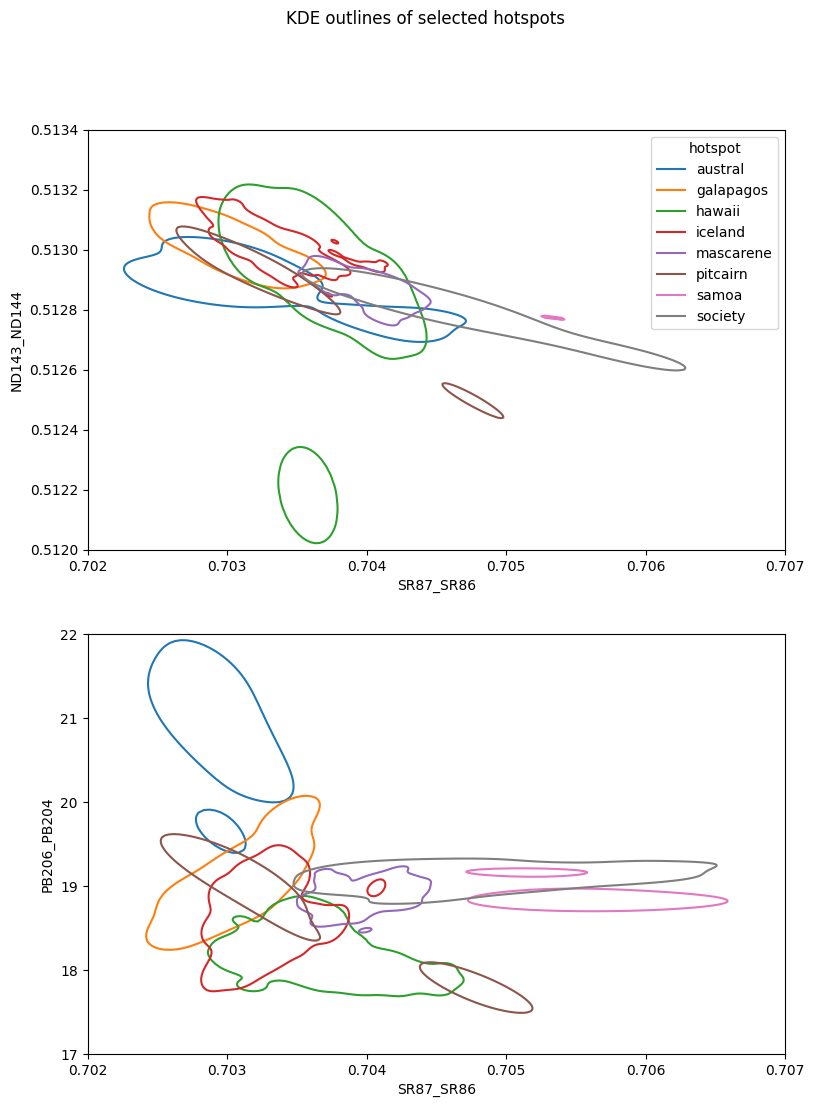

In [ ]:
# Generate KDE contour plot for reference
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

selected_hotspots_merged = pd.concat([austral_SrNdPb, galapagos_SrNdPb, hawaii_SrNdPb,
                                      iceland_SrNdPb, mascarene_SrNdPb, pitcairn_SrNdPb,
                                      samoa_SrNdPb, society_SrNdPb
                                      ], axis=0, ignore_index=True
                                     ).reset_index()

fig, axes = plt.subplots(2, 1, figsize = (9, 12))
fig.suptitle("KDE outlines of selected hotspots")

sns.kdeplot(ax=axes[0], data=selected_hotspots_merged, x="SR87_SR86", y="ND143_ND144",
            levels=1, thresh=0.05, hue="hotspot")
axes[0].set_xlim(0.702,0.707)
axes[0].set_ylim(0.512, 0.5134)

sns.kdeplot(ax=axes[1], data=selected_hotspots_merged, x="SR87_SR86", y="PB206_PB204",
            levels=1, thresh=0.05, hue="hotspot", legend=False)
axes[1].set_xlim(0.702,0.707)
axes[1].set_ylim(17, 22)

plt.show()

The KDE plot generally shows an expected distribution of isotopic compositions for each hotsplot. However, it does reveal some interesting information. First, it shows that the enriched components of some hotspots, such as Hawai'i (e.g., low 143Nd/144Nd), are likely statstically distinct clusters compared to the main body of data lying around FOZO, the intersection point of all hotspots. However, there are some hotspots, such as Samoa and Pitcairn, that clearly group most strongly around their most enriched components (e.g., high 87Sr/86Sr) and farther away from other hotspots. This is perhaps a first preview of what to expect from clustering analysis, with these distinct enriched materials potentially forming distinct clusters.

# **3. Dimensionality reduction using t-SNE and comparison to the results of Stracke et al. (2022)**

In [ ]:
# Normalize data so that differences in the range of each feature don't affect results of t-SNE analysis
SrNdPb_allhotspots['SR87_SR86_N'] = SrNdPb_allhotspots['SR87_SR86'] / SrNdPb_allhotspots['SR87_SR86'].max()

def normalize(data):
  return (data - data.mean()) / (data.max() - data.min())

SrNdPb_allhotspots['SR87_SR86_N'] = normalize(SrNdPb_allhotspots['SR87_SR86'])
SrNdPbTE_allhotspots['SR87_SR86_N'] = normalize(SrNdPbTE_allhotspots['SR87_SR86'])
HeSrNdPb_allhotspots['SR87_SR86_N'] = normalize(HeSrNdPb_allhotspots['SR87_SR86'])

SrNdPb_allhotspots['ND143_ND144_N'] = normalize(SrNdPb_allhotspots['ND143_ND144'])
SrNdPbTE_allhotspots['ND143_ND144_N'] = normalize(SrNdPbTE_allhotspots['ND143_ND144'])
HeSrNdPb_allhotspots['ND143_ND144_N'] = normalize(HeSrNdPb_allhotspots['ND143_ND144'])

SrNdPb_allhotspots['PB206_PB204_N'] = normalize(SrNdPb_allhotspots['PB206_PB204'])
SrNdPbTE_allhotspots['PB206_PB204_N'] = normalize(SrNdPbTE_allhotspots['PB206_PB204'])
HeSrNdPb_allhotspots['PB206_PB204_N'] = normalize(HeSrNdPb_allhotspots['PB206_PB204'])

SrNdPb_allhotspots['PB207_PB204_N'] = normalize(SrNdPb_allhotspots['PB207_PB204'])
SrNdPbTE_allhotspots['PB207_PB204_N'] = normalize(SrNdPbTE_allhotspots['PB207_PB204'])
HeSrNdPb_allhotspots['PB207_PB204_N'] = normalize(HeSrNdPb_allhotspots['PB207_PB204'])

SrNdPb_allhotspots['PB208_PB204_N'] = normalize(SrNdPb_allhotspots['PB208_PB204'])
SrNdPbTE_allhotspots['PB208_PB204_N'] = normalize(SrNdPbTE_allhotspots['PB208_PB204'])
HeSrNdPb_allhotspots['PB208_PB204_N'] = normalize(HeSrNdPb_allhotspots['PB208_PB204'])

HeSrNdPb_allhotspots['HE3_HE4(R/R(A))_N'] = normalize(HeSrNdPb_allhotspots['HE3_HE4(R/R(A))'])

# Create analysis-ready datasets with only data to be analyzed
SrNdPb_allhotspots_dataonly = SrNdPb_allhotspots[['SR87_SR86_N', 'ND143_ND144_N', 'PB206_PB204_N', 'PB207_PB204_N', 'PB208_PB204_N']]

SrNdPbTE_allhotspots_dataonly = SrNdPbTE_allhotspots[['SR87_SR86_N', 'ND143_ND144_N', 'PB206_PB204_N', 'PB207_PB204_N', 'PB208_PB204_N', 'NB(PPM)', 'BA(PPM)', 'LA(PPM)', 'CE(PPM)', 'PB(PPM)', 'U(PPM)']]
SrNdPbTE_allhotspots_dataonly['NbU_N'] = normalize((SrNdPbTE_allhotspots_dataonly['NB(PPM)'] / SrNdPbTE_allhotspots_dataonly['U(PPM)']).replace([np.inf, -np.inf]).dropna())
SrNdPbTE_allhotspots_dataonly['BaLa_N'] = normalize((SrNdPbTE_allhotspots_dataonly['BA(PPM)'] / SrNdPbTE_allhotspots_dataonly['LA(PPM)']).replace([np.inf, -np.inf]).dropna())
SrNdPbTE_allhotspots_dataonly['CePb_N'] = normalize((SrNdPbTE_allhotspots_dataonly['CE(PPM)'] / SrNdPbTE_allhotspots_dataonly['PB(PPM)']).replace([np.inf, -np.inf]).dropna())
SrNdPbTE_allhotspots_dataonly.drop(['NB(PPM)', 'BA(PPM)', 'LA(PPM)', 'CE(PPM)', 'PB(PPM)', 'U(PPM)'], axis=1, inplace=True)

HeSrNdPb_allhotspots_dataonly = HeSrNdPb_allhotspots[['HE3_HE4(R/R(A))_N', 'SR87_SR86_N', 'ND143_ND144_N', 'PB206_PB204_N', 'PB207_PB204_N', 'PB208_PB204_N']]

<ipython-input-5-180e1d5d98ba>:33: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  SrNdPbTE_allhotspots_dataonly['NbU_N'] = normalize((SrNdPbTE_allhotspots_dataonly['NB(PPM)'] / SrNdPbTE_allhotspots_dataonly['U(PPM)']).replace([np.inf, -np.inf]).dropna())
<ipython-input-5-180e1d5d98ba>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SrNdPbTE_allhotspots_dataonly['NbU_N'] = normalize((SrNdPbTE_allhotspots_dataonly['NB(PPM)'] / SrNdPbTE_allhotspots_dataonly['U(PPM)']).replace([np.inf, -np.inf]).dropna())
<ipython-input-5-180e1d5d98ba>:34: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' 

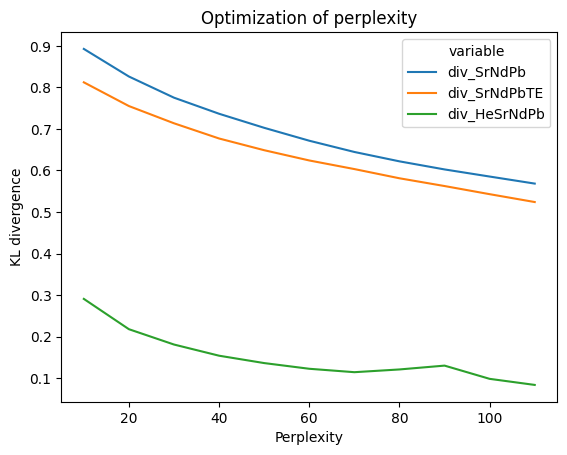

In [ ]:
# Test values of perplexity hyperparameter for t-SNE on main Sr-Nd-Pb sub-dataset
from sklearn.manifold import TSNE

perplexity = np.arange(10, 120, 10)
divergence_SrNdPb = []
divergence_SrNdPbTE = []
divergence_HeSrNdPb = []

for i in perplexity:
  tsne_SrNdPb = TSNE(n_components=2, init='pca', perplexity=i)
  SrNdPb_allhotspots_optperp = tsne_SrNdPb.fit_transform(SrNdPb_allhotspots_dataonly)

  tsne_SrNdPbTE = TSNE(n_components=2, init='pca', perplexity=i)
  SrNdPbTE_allhotspots_optperp = tsne_SrNdPbTE.fit_transform(SrNdPbTE_allhotspots_dataonly)

  tsne_HeSrNdPb = TSNE(n_components=2, init='pca', perplexity=i)
  HeSrNdPb_allhotspots_optperp = tsne_HeSrNdPb.fit_transform(HeSrNdPb_allhotspots_dataonly)

  divergence_SrNdPb.append(tsne_SrNdPb.kl_divergence_)
  divergence_SrNdPbTE.append(tsne_SrNdPbTE.kl_divergence_)
  divergence_HeSrNdPb.append(tsne_HeSrNdPb.kl_divergence_)

# Organize results
results = pd.DataFrame({'perplexity': perplexity,
                        'div_SrNdPb': divergence_SrNdPb,
                        'div_SrNdPbTE': divergence_SrNdPbTE,
                        'div_HeSrNdPb': divergence_HeSrNdPb})
results = pd.melt(results, ['perplexity'])

# Produce plot
sns.lineplot(data=results, x='perplexity', y='value', hue='variable').set(title='Optimization of perplexity', xlabel='Perplexity', ylabel='KL divergence')
plt.show()

The divergence clearly is continuing to decrease with increasing perplexity, but one cannot increase the perplexity infinitely without overfitting the dataset. For this exercise, I will use a perplexity of 70, which lies on the plateau minimum for the He-Sr-Nd-Pb isotopic sub-dataset. This is already somewhat above the recommended range of 5-50.

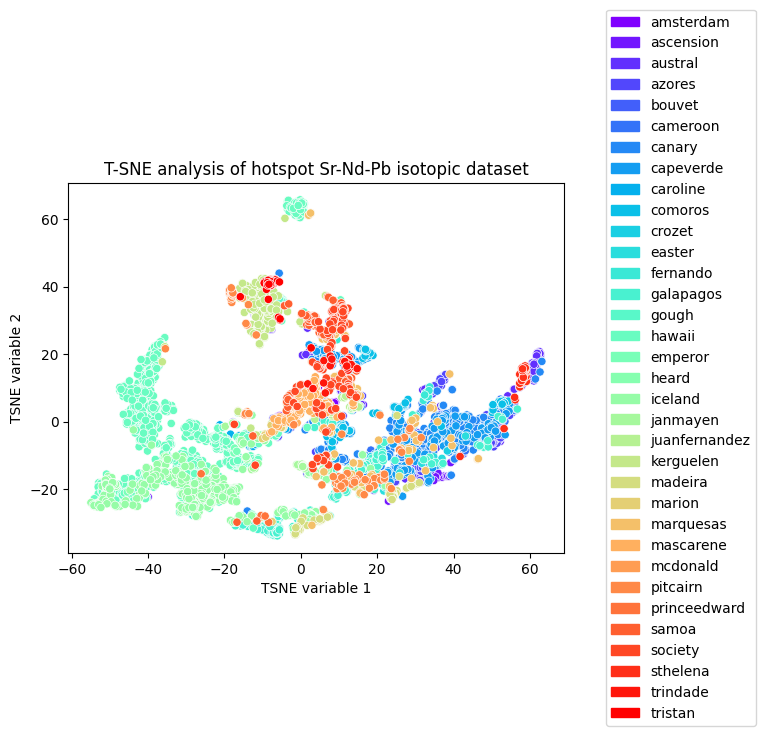

In [ ]:
# Perform optimized t-SNE on main Sr-Nd-Pb dataset for initial comparison to Stracke et al. (2022 G-Cubed)
# Prepare for plotting
import seaborn as sns
import matplotlib.pyplot as plt
import colorsys
import matplotlib.patches as mpatches
from matplotlib.pyplot import cm

hotspots = SrNdPb_allhotspots['hotspot'].unique()
n = len(hotspots)
colors = cm.rainbow(np.linspace(0,1,n))
color_dict = {hotspots[i]: colors[i] for i in range(n)}
patches = []

for hotspot in hotspots:
  patches.append(mpatches.Patch(color=color_dict[hotspot], label=hotspot))

# Perform clustering model and plot results
tsne = TSNE(n_components=2, init='pca', perplexity=70, random_state=23)
SrNdPb_allhotspots_tsne = tsne.fit_transform(SrNdPb_allhotspots_dataonly)

# Organize results
tsne_result = pd.DataFrame({'tsne_1': SrNdPb_allhotspots_tsne[:,0],
                            'tsne_2': SrNdPb_allhotspots_tsne[:,1],
                            'hotspot': SrNdPb_allhotspots['hotspot']})

# Visualize results
sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result, hue='hotspot', palette=color_dict)
plt.legend(handles=patches, loc='right', bbox_to_anchor=(1.4, 0.5))
plt.title('T-SNE analysis of hotspot Sr-Nd-Pb isotopic dataset')
plt.xlabel('TSNE variable 1')
plt.ylabel('TSNE variable 2')
plt.show()

Clearly the results are complex and the number of hotspots means that many of them are plotted with very similar colors and will require separate rendering to identify where each hotspot is clustering. However, some patterns are immediately clear. There appear to be three main groups, where one (bottom left) is dominated by Hawai'i. There is also a clearly separate, small cluster of Hawai'i and a few Marion hotspot samples that may represent the separate enriched component of Hawai'i previously identified on the KDE plots. It is clear that these results are very unlike those of Stracke et al. (2022) in that this analysis results in fewer distinct groups. This is most likely because the resolving power of the model is still limited by the input perplexity, so a survey of other perplexity values will be used to try to reproduce their results. However, it is noteworthy that Stracke et al. (2022) claims that they use the default perplexity value of 30, although their result is not reproduced here for similar perplexity values.

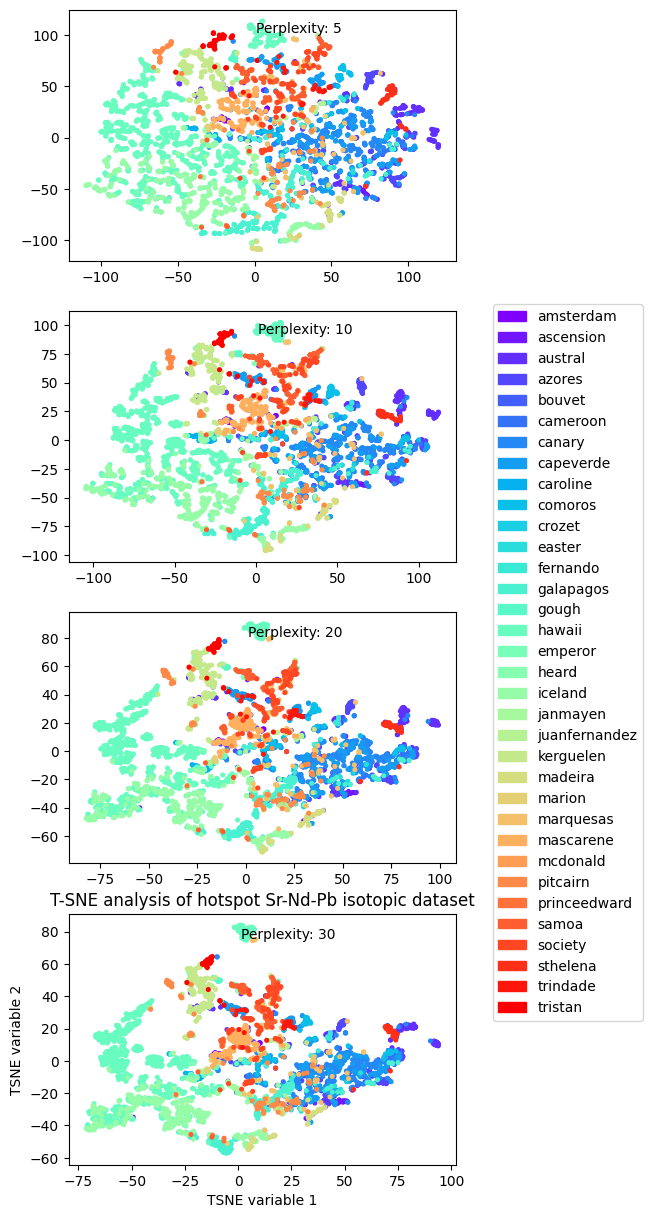

In [ ]:
# Perform TSNE on main Sr-Nd-Pb dataset with variable perplexity values around those of Stracke et al. 2022 to try and more closely reproduce their results

# Identify perplexity values to compare
perplexity_values = [5, 10, 20, 30]
params = ({"perplexity": 5}, {"perplexity": 10}, {"perplexity": 20}, {"perplexity": 30})

# Prepare for plotting
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(5, 15))
hotspots = SrNdPb_allhotspots['hotspot'].unique()
n = len(hotspots)
colors = cm.rainbow(np.linspace(0,1,n))
color_dict = {hotspots[i]: colors[i] for i in range(n)}
patches = []
for hotspot in hotspots:
  patches.append(mpatches.Patch(color=color_dict[hotspot], label=hotspot))

# Cycle through perplexity values to build plots
for i, param in enumerate(params):
  # Perform TSNE fit
  tsne = TSNE(n_components=2, init='pca', perplexity=param['perplexity'], random_state=23)
  SrNdPb_allhotspots_tsne = tsne.fit_transform(SrNdPb_allhotspots_dataonly)

  # Organize results
  tsne_result = pd.DataFrame({'tsne_1': SrNdPb_allhotspots_tsne[:,0],
                              'tsne_2': SrNdPb_allhotspots_tsne[:,1],
                              'hotspot': SrNdPb_allhotspots['hotspot']})

  # Visualize results
  axes[i].scatter(x=tsne_result['tsne_1'],
                  y=tsne_result['tsne_2'],
                  c=tsne_result['hotspot'].map(color_dict),
                  label = hotspot[i],
                  s=7)
  axes[i].text(s=f'Perplexity: {perplexity_values[i]}', x=1.1, y=0.9*SrNdPb_allhotspots_tsne[:,1].max())

# Visualize results
plt.legend(handles=patches, loc='right', bbox_to_anchor=(1.5, 2))
plt.title('T-SNE analysis of hotspot Sr-Nd-Pb isotopic dataset')
plt.xlabel('TSNE variable 1')
plt.ylabel('TSNE variable 2')
plt.show()

Variable perplexity does not fully explain the differences observed between these results and those of Stracke et al. (2022). Lower perplexity does result in the appearence of several smaller, possibly discrete groups like what is observed in Stracke et al., however the groups are not as distinct and do not as clearly divide individual hotspots into separate groups. Further, their results do not reflect the bias of the overall dataset toward samples from Hawai'i and Iceland, and they do not state that they undertake any data filtering or normalization to account for this. There are potentially other hyperparameter settings that Stracke et al. (2022) used but did not report, and based on conversations with colleagues, their results have not so far been reproducible in other groups.

Now the basic optimized model will be compared using different datasets that include either trace element or He isotopic data. A reduced dataset of "selected" hotspots will be used to improve the clarity of visualizations, which will include hotspots representing the main recognized mantle "components" FOZO, HIMU, EM, and DM. Hotspots Juan Fernandez and Crozet will be additionally included, although there is comparatively little data for them, because they are the focus of the parallel lab study.

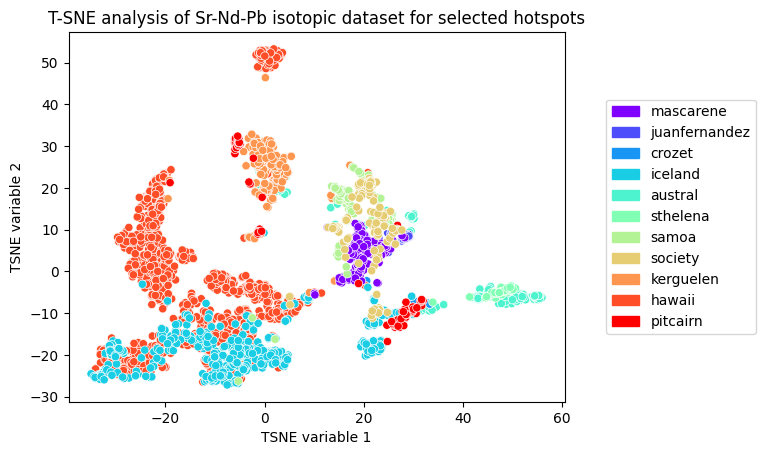

In [ ]:
# Perform optimized TSNE on Sr-Nd-Pb dataset for selected hotspot representatives of each subtype for additional clarity
# FOZO - Mascarene, Juan Fernandez, Iceland, Crozet
# DM - Iceland
# HIMU - Austral, St. Helena
# EM - Samoa (EM-2 endmember), Society, Kerguelen, Hawai'i, Pitcairn (EM-1 endmember)

# Slice datasets
selhotspots = ['mascarene', 'juanfernandez', 'crozet', 'iceland', 'austral', 'sthelena', 'samoa', 'society', 'kerguelen', 'hawaii', 'pitcairn']

SrNdPb_selhotspots = SrNdPb_allhotspots.loc[SrNdPb_allhotspots['hotspot'].isin(selhotspots)]
SrNdPb_selhotspots_dataonly = SrNdPb_allhotspots_dataonly.loc[SrNdPb_allhotspots['hotspot'].isin(selhotspots)]

# Prepare for plotting
n = len(selhotspots)
colors = cm.rainbow(np.linspace(0,1,n))
color_dict = {selhotspots[i]: colors[i] for i in range(n)}
patches = []
for hotspot in selhotspots:
  patches.append(mpatches.Patch(color=color_dict[hotspot], label=hotspot))

# Perform clustering model and plot results
tsne = TSNE(n_components=2, init='pca', perplexity=70, random_state=23)
SrNdPb_selhotspots_tsne = tsne.fit_transform(SrNdPb_selhotspots_dataonly)

# Organize results
tsne_result = pd.DataFrame({'tsne_1': SrNdPb_selhotspots_tsne[:,0],
                            'tsne_2': SrNdPb_selhotspots_tsne[:,1],
                            'hotspot': SrNdPb_selhotspots['hotspot']})

# Visualize results
sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result, hue='hotspot', palette=color_dict)
plt.legend(handles=patches, loc='right', bbox_to_anchor=(1.4, 0.5))
plt.title('T-SNE analysis of Sr-Nd-Pb isotopic dataset for selected hotspots')
plt.xlabel('TSNE variable 1')
plt.ylabel('TSNE variable 2')
plt.show()

When only plotting some key hotspots, the t-SNE groups become much more distinct. Several distinct groups can be noted:

- A HIMU-type hotspot group, containing some St. Helena and Austral samples. Other lavas from these hotspots plot in other groups, particularly the FOZO cluster, consistent with the range of compositions in those hotspots between HIMU and FOZO

- A group containing the dominantly FOZO-type hotspots Juan Fernandez and Mascarene (Reunion). Interestingly, nearly all Society samples plot in this area as well, possibly reflecting the dominant role for FOZO-like compositions linking the EM- (clustered with Pitcairn) and HIMU-type (not represented in this dataset) lavas in the Society islands.

- A group containing most Pitcairn samples, along with some Society and Iceland lava samples. This perhaps corresponds to a unique EM-type composition approximating "EM-1"

- A group containing most Kerguelen samples, along with some Pitcairn samples. This perhaps corresponds to a second unique EM-type composition that partially overlaps with the Pitcairn-type EM composition.

- A small group containing some Hawai'i samples, probably corresponding to the enriched Loa trend lavas noted by Dominique Weis and others.

- A very large group containing most Hawai'i and Iceland samples, along with a few samples from other hotspots. This is a curious group because it overlaps neither with the FOZO-associated group, even though FOZO is a major component of these hotspots, nor with the EM1-associated group, which is a component present at least in Hawai'i if not also in Iceland. The meaning of this group is not immediately clear.

The behavior of Samoa is also notable. Although Samoa is recognized as being a type endmember for an "EM-2" component, it plots primarily in the FOZO-associated group. The EM2-like compositions are, however, definitely in this dataset, as seen in the KDE plots. A few Samoa samples plot on the edge of the Kerguelen group, which perhaps makes sense since Kerguelen has an EM composition intermediate to EM-1 and EM-2 and thus could be considered to partially overlap with both (in this case, to have samples from both Pitcairn and Samoa in the same group, but on opposite sides of the group).

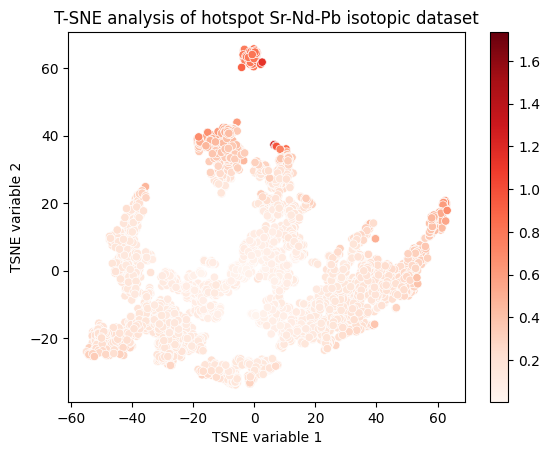

In [ ]:
# Perform optimized TSNE on full Sr-Nd-Pb dataset with color coding for distance from a classical FOZO component

# Add column to Sr-Nd-Pb dataset representing distance from FOZO as a function of total isotopic range observed in hotspots
SR87_SR86_FOZO = 0.7035
ND143_ND144_FOZO = 0.5129
PB206_PB204_FOZO = 18.8

SR87_SR86_MAX = 0.7186
SR87_SR86_MIN = 0.7025

ND143_ND144_MIN = 0.5123
ND143_ND144_MAX = 0.5132

PB206_PB204_MIN = 17.5
PB206_PB204_MAX = 22

SrNdPb_allhotspots['D_SrNdPb'] = (((SrNdPb_allhotspots['SR87_SR86'] - SR87_SR86_FOZO)/(SR87_SR86_MAX - SR87_SR86_MIN))**2 +
                                  ((SrNdPb_allhotspots['ND143_ND144'] - ND143_ND144_FOZO)/(ND143_ND144_MAX - ND143_ND144_MIN))**2 +
                                  ((SrNdPb_allhotspots['PB206_PB204'] - PB206_PB204_FOZO)/(PB206_PB204_MAX - PB206_PB204_MIN))**2)**0.5

# Prepare for plotting
hotspots = SrNdPb_allhotspots['hotspot'].unique()
n = len(hotspots)
colors = cm.rainbow(np.linspace(0,1,n))
color_dict = {hotspots[i]: colors[i] for i in range(n)}
patches = []
for hotspot in hotspots:
  patches.append(mpatches.Patch(color=color_dict[hotspot], label=hotspot))

# Perform clustering model and plot results
tsne = TSNE(n_components=2, init='pca', perplexity=70, random_state=23)
SrNdPb_allhotspots_tsne = tsne.fit_transform(SrNdPb_allhotspots_dataonly)

# Organize results
tsne_result = pd.DataFrame({'tsne_1': SrNdPb_allhotspots_tsne[:,0],
                            'tsne_2': SrNdPb_allhotspots_tsne[:,1],
                            'D_SrNdPb': SrNdPb_allhotspots['D_SrNdPb']})

# Visualize results
ax = sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result, hue='D_SrNdPb', palette='Reds')
ax.get_legend().remove()
ax.figure.colorbar(plt.cm.ScalarMappable(cmap='Reds',
                                         norm=plt.Normalize(SrNdPb_allhotspots['D_SrNdPb'].min(), SrNdPb_allhotspots['D_SrNdPb'].max())),
                   ax=ax)
ax.set_title('T-SNE analysis of hotspot Sr-Nd-Pb isotopic dataset')
ax.set_xlabel('TSNE variable 1')
ax.set_ylabel('TSNE variable 2')
plt.show()



This result confirms my suspicion that the samples with the most FOZO-like compositions do tend to plot in the center of the diagram, i.e. they occupy parts of groups that "face each other." However, the fact that many of them do end up in different groups is notable and perhaps this will be understood better when we bring in more data parameters.

For future investigation: it is not immediately clear why the shape and sizes of the groups are distinct in this model compared to the last, since they nominally have the same model setup.

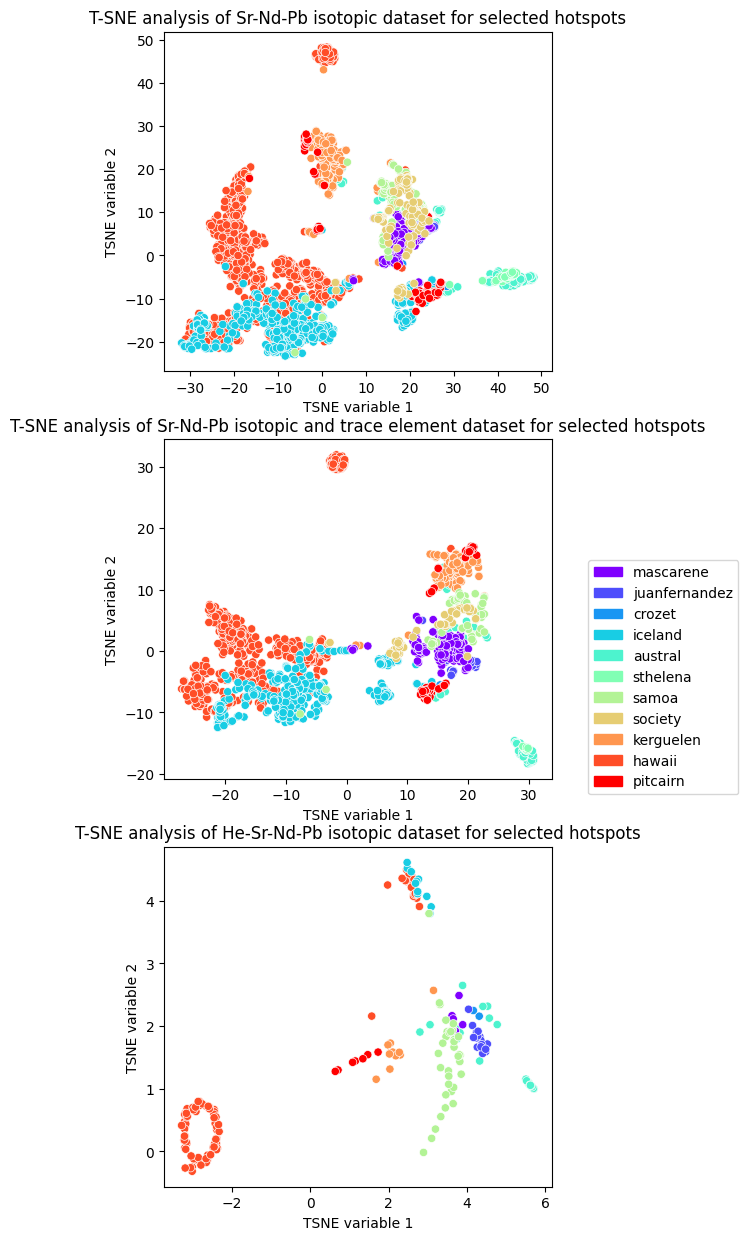

In [ ]:
# Perform optimized TSNE on the selected hotspot dataset for databases that include either trace element data or He isotopic data
# FOZO - Mascarene, Juan Fernandez, Iceland, Crozet
# HIMU - Austral, St. Helena
# EM - Samoa, Society, Kerguelen, Hawai'i, Pitcairn

# Slice remaining datasets
SrNdPbTE_selhotspots = SrNdPbTE_allhotspots.loc[SrNdPbTE_allhotspots['hotspot'].isin(selhotspots)]
SrNdPbTE_selhotspots_dataonly = SrNdPbTE_allhotspots_dataonly.loc[SrNdPbTE_allhotspots['hotspot'].isin(selhotspots)]

HeSrNdPb_selhotspots = HeSrNdPb_allhotspots.loc[HeSrNdPb_allhotspots['hotspot'].isin(selhotspots)]
HeSrNdPb_selhotspots_dataonly = HeSrNdPb_allhotspots_dataonly.loc[HeSrNdPb_allhotspots['hotspot'].isin(selhotspots)]

# Prepare for plotting
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(5, 15))
n = len(selhotspots)
colors = cm.rainbow(np.linspace(0,1,n))
color_dict = {selhotspots[i]: colors[i] for i in range(n)}
patches = []
for hotspot in selhotspots:
  patches.append(mpatches.Patch(color=color_dict[hotspot], label=hotspot))

# Perform clustering model and plot results
tsne = TSNE(n_components=2, init='pca', perplexity=90, random_state=23)

SrNdPb_selhotspots_tsne = tsne.fit_transform(SrNdPb_selhotspots_dataonly)
SrNdPbTE_selhotspots_tsne = tsne.fit_transform(SrNdPbTE_selhotspots_dataonly)
HeSrNdPb_selhotspots_tsne = tsne.fit_transform(HeSrNdPb_selhotspots_dataonly)

# Organize results
tsne_result_SrNdPb_selhotspots = pd.DataFrame({'tsne_1': SrNdPb_selhotspots_tsne[:,0],
                                               'tsne_2': SrNdPb_selhotspots_tsne[:,1],
                                               'hotspot': SrNdPb_selhotspots['hotspot']})
tsne_result_SrNdPbTE_selhotspots = pd.DataFrame({'tsne_1': SrNdPbTE_selhotspots_tsne[:,0],
                                                 'tsne_2': SrNdPbTE_selhotspots_tsne[:,1],
                                                 'hotspot': SrNdPbTE_selhotspots['hotspot']})
tsne_result_HeSrNdPb_selhotspots = pd.DataFrame({'tsne_1': HeSrNdPb_selhotspots_tsne[:,0],
                                                 'tsne_2': HeSrNdPb_selhotspots_tsne[:,1],
                                                 'hotspot': HeSrNdPb_selhotspots['hotspot']})

# Visualize results
sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result_SrNdPb_selhotspots, hue='hotspot', palette=color_dict, ax=ax1)
ax1.set_title('T-SNE analysis of Sr-Nd-Pb isotopic dataset for selected hotspots')
ax1.set_xlabel('TSNE variable 1')
ax1.set_ylabel('TSNE variable 2')
ax1.legend_.remove()

sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result_SrNdPbTE_selhotspots, hue='hotspot', palette=color_dict, ax=ax2)
ax2.set_title('T-SNE analysis of Sr-Nd-Pb isotopic and trace element dataset for selected hotspots')
ax2.set_xlabel('TSNE variable 1')
ax2.set_ylabel('TSNE variable 2')
ax2.legend_.remove()

sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result_HeSrNdPb_selhotspots, hue='hotspot', palette=color_dict, ax=ax3)
ax3.set_title('T-SNE analysis of He-Sr-Nd-Pb isotopic dataset for selected hotspots')
ax3.set_xlabel('TSNE variable 1')
ax3.set_ylabel('TSNE variable 2')
ax3.legend_.remove()

# Add legend & show plot
plt.legend(handles=patches, loc='right', bbox_to_anchor=(1.5, 1.5))
plt.show()

The incorporation of trace element or He isotopic data has a significant influence on the resulting groupings. In the case of trace elements, the following differences are observed:
- Samoan lavas become more distinct from the FOZO-associated group, plotting on the side toward the Kerguelen group
- Society lavas are more distinctly broken into their FOZO-like (near mascarene) and EM-like (overlapping Samoa) groups
- Some Iceland lavas previously associated with the Pitcairn or EM1-associated group are broken off into a separate group
- The HIMU-associated group and the enriched Hawai'i group plot farther away from the other groups

The results including He isotopic data are even more striking. Now, the hotspots are almost completely separated, with a few exceptions:
- Iceland, some Hawai'i, and one Samoa lava occupy a group that is distinct from the others. This perhaps reflects the group of highest-3He/4He ocean island basalts, this will need to be verified manually.
- The remainder of Hawai'i lavas plot in a distinct group far away from other hotspots
- Mascarene lavas lie at the center of the group groups, close to Juan Fernandez. Samoa, Kerguelen, Pitcairn, and to a lesser extent Austral lavas radiate from this point
These observations would seem to imply that the He isotopic signatures of each hotspot are unrelated to their Sr-Nd-Pb isotopic compositions in 4-D space and may therefore have distinct origins. Moreover, hotspots with similar ranges of 3He/4He ratios, such as Mascarene and Juan Fernandez lavas, do not overlap in TSNE variable space.

Now, these sub-datasets will be used in clustering models to more quantitatively identify distinct groups of hotspots.

# **4. Cluster analysis of reduced-dimension data using k-means**

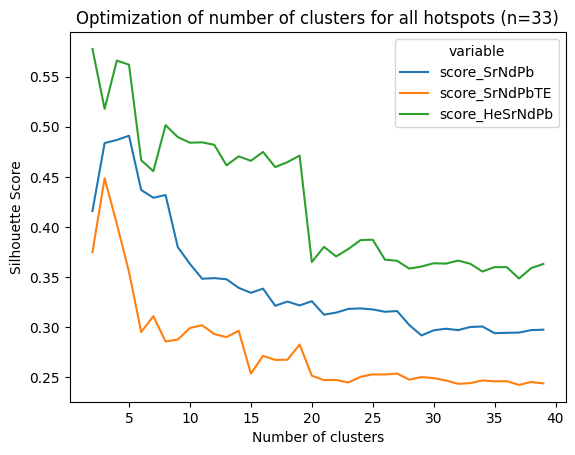

In [ ]:
# k-Means clustering: optimize number of clusters using the Elbow method for all hotspots
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusters = range(2, 40)
fits_SrNdPb = []
fits_SrNdPbTE = []
fits_HeSrNdPb = []
score_SrNdPb = []
score_SrNdPbTE = []
score_HeSrNdPb = []

for cluster in clusters:
  model_SrNdPb = KMeans(n_clusters=cluster, random_state=23, n_init='auto')
  model_SrNdPbTE = KMeans(n_clusters=cluster, random_state=23, n_init='auto')
  model_HeSrNdPb = KMeans(n_clusters=cluster, random_state=23, n_init='auto')

  SrNdPb_model = model_SrNdPb.fit(SrNdPb_allhotspots_dataonly)
  SrNdPbTE_model = model_SrNdPbTE.fit(SrNdPbTE_allhotspots_dataonly)
  HeSrNdPb_model = model_HeSrNdPb.fit(HeSrNdPb_allhotspots_dataonly)

  fits_SrNdPb.append(SrNdPb_model)
  fits_SrNdPbTE.append(SrNdPbTE_model)
  fits_HeSrNdPb.append(HeSrNdPb_model)

  score_SrNdPb.append(silhouette_score(SrNdPb_allhotspots_dataonly, SrNdPb_model.labels_, metric='euclidean'))
  score_SrNdPbTE.append(silhouette_score(SrNdPbTE_allhotspots_dataonly, SrNdPbTE_model.labels_, metric='euclidean'))
  score_HeSrNdPb.append(silhouette_score(HeSrNdPb_allhotspots_dataonly, HeSrNdPb_model.labels_, metric='euclidean'))

# Organize results
results = pd.DataFrame({'clusters': clusters,
                        'score_SrNdPb': score_SrNdPb,
                        'score_SrNdPbTE': score_SrNdPbTE,
                        'score_HeSrNdPb': score_HeSrNdPb})
results = pd.melt(results, ['clusters'])

# Produce plot
sns.lineplot(data=results, x='clusters', y='value', hue='variable').set(title='Optimization of number of clusters for all hotspots (n=33)', xlabel='Number of clusters', ylabel='Silhouette Score')
plt.show()

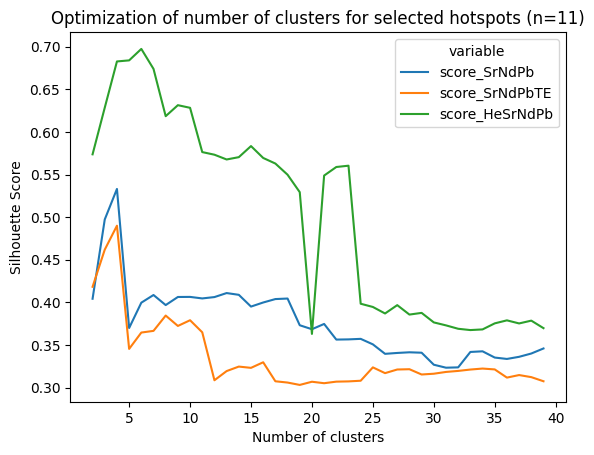

In [ ]:
# k-Means clustering: optimize number of clusters using the Elbow method for selected hotspots

clusters = range(2, 40)
fits_SrNdPb = []
fits_SrNdPbTE = []
fits_HeSrNdPb = []
score_SrNdPb = []
score_SrNdPbTE = []
score_HeSrNdPb = []

for cluster in clusters:
  model_SrNdPb = KMeans(n_clusters=cluster, random_state=23, n_init='auto')
  model_SrNdPbTE = KMeans(n_clusters=cluster, random_state=23, n_init='auto')
  model_HeSrNdPb = KMeans(n_clusters=cluster, random_state=23, n_init='auto')

  SrNdPb_model = model_SrNdPb.fit(SrNdPb_selhotspots_dataonly)
  SrNdPbTE_model = model_SrNdPbTE.fit(SrNdPbTE_selhotspots_dataonly)
  HeSrNdPb_model = model_HeSrNdPb.fit(HeSrNdPb_selhotspots_dataonly)

  fits_SrNdPb.append(SrNdPb_model)
  fits_SrNdPbTE.append(SrNdPbTE_model)
  fits_HeSrNdPb.append(HeSrNdPb_model)

  score_SrNdPb.append(silhouette_score(SrNdPb_selhotspots_dataonly, SrNdPb_model.labels_, metric='euclidean'))
  score_SrNdPbTE.append(silhouette_score(SrNdPbTE_selhotspots_dataonly, SrNdPbTE_model.labels_, metric='euclidean'))
  score_HeSrNdPb.append(silhouette_score(HeSrNdPb_selhotspots_dataonly, HeSrNdPb_model.labels_, metric='euclidean'))

# Organize results
results = pd.DataFrame({'clusters': clusters,
                        'score_SrNdPb': score_SrNdPb,
                        'score_SrNdPbTE': score_SrNdPbTE,
                        'score_HeSrNdPb': score_HeSrNdPb})
results = pd.melt(results, ['clusters'])

# Produce plot
sns.lineplot(data=results, x='clusters', y='value', hue='variable').set(title='Optimization of number of clusters for selected hotspots (n=11)', xlabel='Number of clusters', ylabel='Silhouette Score')
plt.show()

The sub-databases for all hotspots show a clear tendency to require more clusters to achieve a lower (better) score, with a lower plateau being reached after ca. 20 clusters, or about 2/3 the number of hotspots represented in the datasets. By contrast, lower plateaus are not reached for the "selected hotspots" sub-datasets until the number of clusters equals or exceeds the number of hotspots in the dataset. For the sub-database including He, the lower plateau is reached at basically the same number of clusters in both the all hotspots and the selected hotspots sub-databases.

For simplicity, only the selected hotspot databases will be used from here forward. For consistency, the same number of clusters will be tested for each sub-dataset in each model run. These will be:
- n=5, corresponding to the same number of clusters as recognized mantle components (depleted mantle, HIMU, EM-1, EM-2, and FOZO). n=6 also added after seeing the results from this test.
- n=10, corresponding to the plateau points for the Sr-Nd-Pb and He-Sr-Nd-Pb sub-datasets
- n=25, corresponding to the possible plateau point for the Sr-Nd-Pb-TE sub-dataset

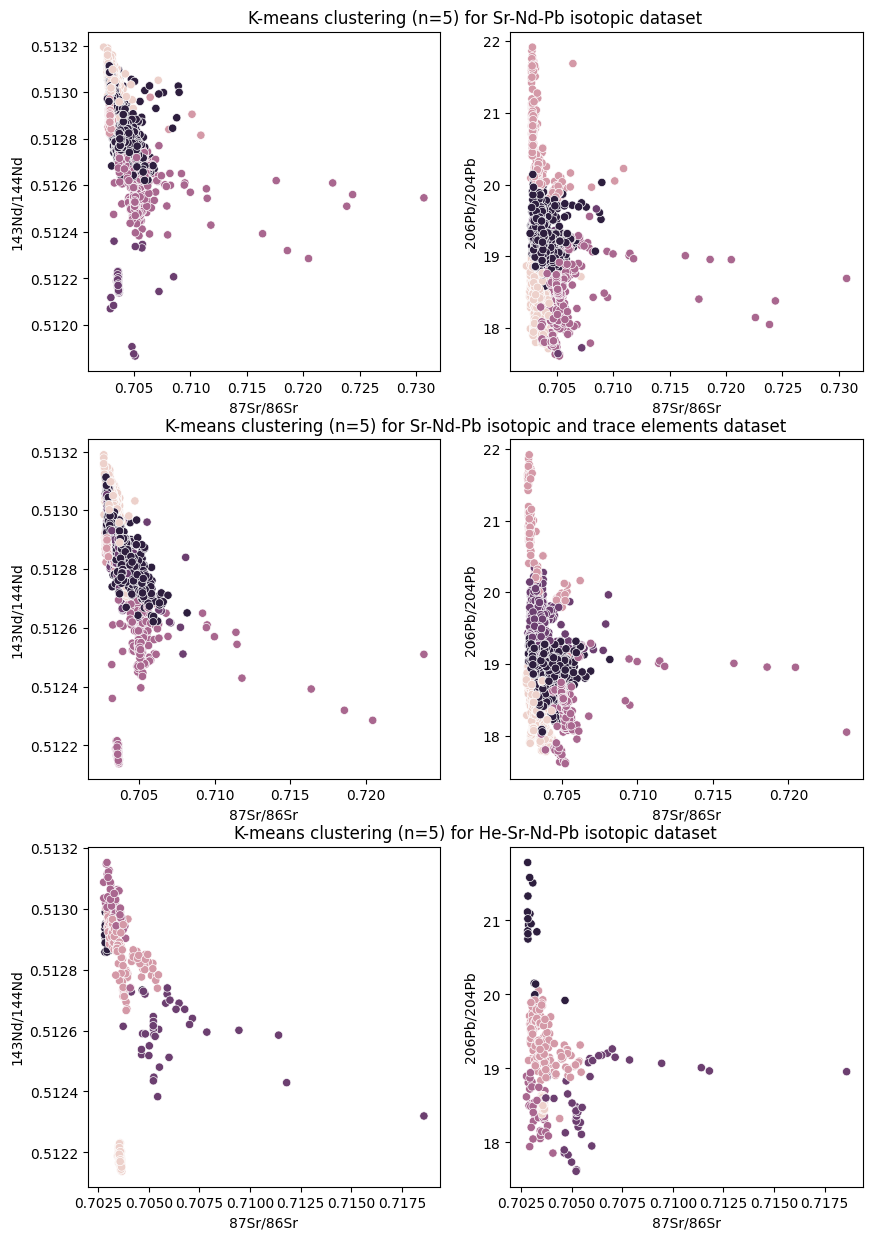

In [ ]:
# Initialize and fit models for each sub-dataset, n(clusters) = 5
kmeans_SrNdPb = KMeans(n_clusters=5, random_state=23, n_init='auto')
kmeans_SrNdPbTE = KMeans(n_clusters=5, random_state=23, n_init='auto')
kmeans_HeSrNdPb = KMeans(n_clusters=5, random_state=23, n_init='auto')

SrNdPb_kmeans = kmeans_SrNdPb.fit(SrNdPb_allhotspots_dataonly)
SrNdPbTE_kmeans = kmeans_SrNdPbTE.fit(SrNdPbTE_allhotspots_dataonly)
HeSrNdPb_kmeans = kmeans_HeSrNdPb.fit(HeSrNdPb_allhotspots_dataonly)

# Visualize results
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
ax1, ax2, ax3, ax4, ax5, ax6 = [axes[i, j] for i in range(3) for j in range(2)]

sns.scatterplot(x=SrNdPb_allhotspots['SR87_SR86'], y=SrNdPb_allhotspots['ND143_ND144'], hue=SrNdPb_kmeans.labels_, ax=ax1)
ax1.set_title('K-means clustering (n=5) for Sr-Nd-Pb isotopic dataset', x=1.1, y=1)
ax1.set_xlabel('87Sr/86Sr')
ax1.set_ylabel('143Nd/144Nd')
ax1.legend_.remove()

sns.scatterplot(x=SrNdPb_allhotspots['SR87_SR86'], y=SrNdPb_allhotspots['PB206_PB204'], hue=SrNdPb_kmeans.labels_, ax=ax2)
ax2.set_xlabel('87Sr/86Sr')
ax2.set_ylabel('206Pb/204Pb')
ax2.legend_.remove()

sns.scatterplot(x=SrNdPbTE_allhotspots['SR87_SR86'], y=SrNdPbTE_allhotspots['ND143_ND144'], hue=SrNdPbTE_kmeans.labels_, ax=ax3)
ax3.set_title('K-means clustering (n=5) for Sr-Nd-Pb isotopic and trace elements dataset', x=1.1, y=1)
ax3.set_xlabel('87Sr/86Sr')
ax3.set_ylabel('143Nd/144Nd')
ax3.legend_.remove()

sns.scatterplot(x=SrNdPbTE_allhotspots['SR87_SR86'], y=SrNdPbTE_allhotspots['PB206_PB204'], hue=SrNdPbTE_kmeans.labels_, ax=ax4)
ax4.set_xlabel('87Sr/86Sr')
ax4.set_ylabel('206Pb/204Pb')
ax4.legend_.remove()

sns.scatterplot(x=HeSrNdPb_allhotspots['SR87_SR86'], y=HeSrNdPb_allhotspots['ND143_ND144'], hue=HeSrNdPb_kmeans.labels_, ax=ax5)
ax5.set_title('K-means clustering (n=5) for He-Sr-Nd-Pb isotopic dataset', x=1.1, y=1)
ax5.set_xlabel('87Sr/86Sr')
ax5.set_ylabel('143Nd/144Nd')
ax5.legend_.remove()

sns.scatterplot(x=HeSrNdPb_allhotspots['SR87_SR86'], y=HeSrNdPb_allhotspots['PB206_PB204'], hue=HeSrNdPb_kmeans.labels_, ax=ax6)
ax6.set_xlabel('87Sr/86Sr')
ax6.set_ylabel('206Pb/204Pb')
ax6.legend_.remove()

plt.show()

Generally, when using 5 clusters the model breaks the data into groups that roughly correspond to previously recognized mantle components. However, the EM array tends to be combined into one cluster and the anomalously enriched Hawai'i samples comprise their own cluster. Based on this, will test now using six clusters to see if the EM arrays will be broken up into previously-recognized EM-1 and EM-2 groups.

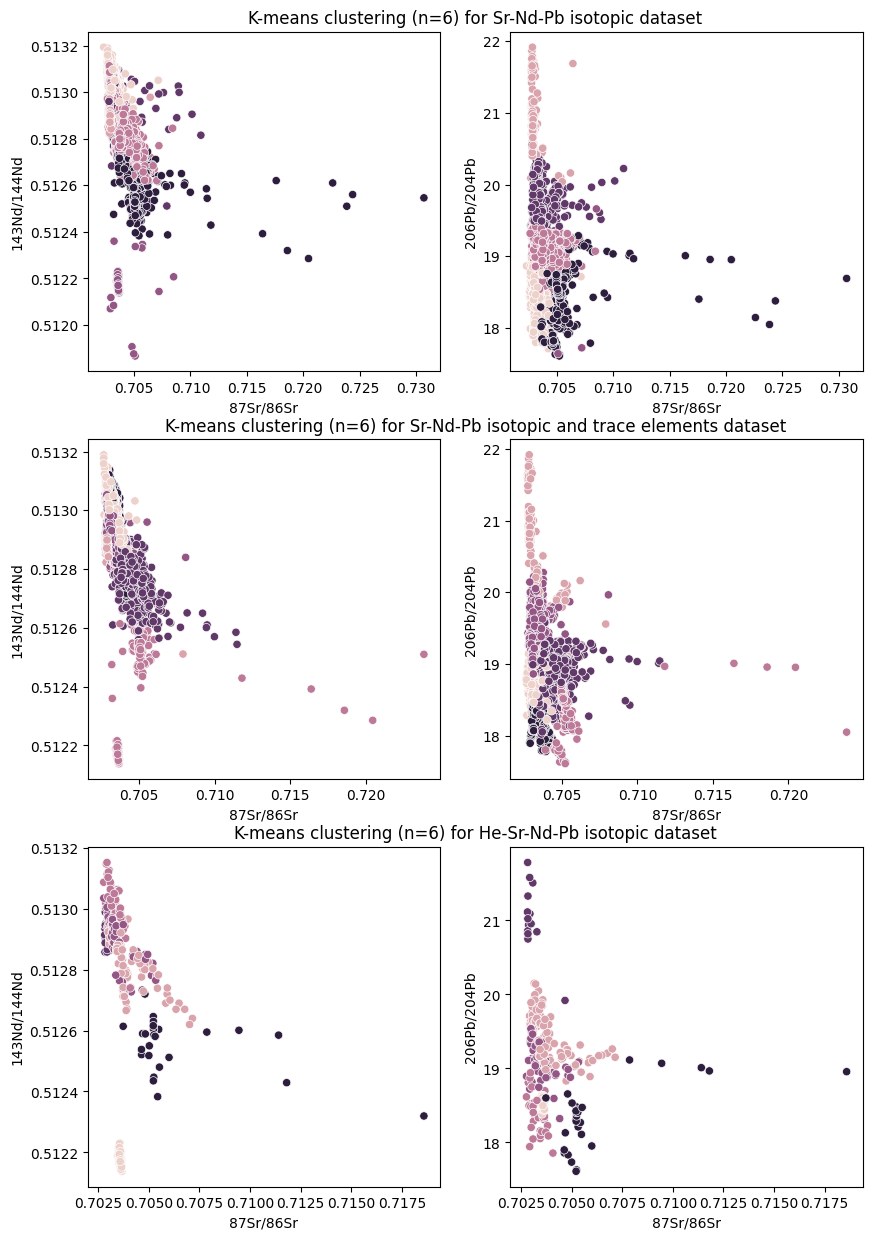

In [ ]:
# Initialize and fit models for each sub-dataset, n(clusters) = 6
kmeans_SrNdPb = KMeans(n_clusters=6, random_state=23, n_init='auto')
kmeans_SrNdPbTE = KMeans(n_clusters=6, random_state=23, n_init='auto')
kmeans_HeSrNdPb = KMeans(n_clusters=6, random_state=23, n_init='auto')

SrNdPb_kmeans = kmeans_SrNdPb.fit(SrNdPb_allhotspots_dataonly)
SrNdPbTE_kmeans = kmeans_SrNdPbTE.fit(SrNdPbTE_allhotspots_dataonly)
HeSrNdPb_kmeans = kmeans_HeSrNdPb.fit(HeSrNdPb_allhotspots_dataonly)

# Visualize results
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
ax1, ax2, ax3, ax4, ax5, ax6 = [axes[i, j] for i in range(3) for j in range(2)]

sns.scatterplot(x=SrNdPb_allhotspots['SR87_SR86'], y=SrNdPb_allhotspots['ND143_ND144'], hue=SrNdPb_kmeans.labels_, ax=ax1)
ax1.set_title('K-means clustering (n=6) for Sr-Nd-Pb isotopic dataset', x=1.1, y=1)
ax1.set_xlabel('87Sr/86Sr')
ax1.set_ylabel('143Nd/144Nd')
ax1.legend_.remove()

sns.scatterplot(x=SrNdPb_allhotspots['SR87_SR86'], y=SrNdPb_allhotspots['PB206_PB204'], hue=SrNdPb_kmeans.labels_, ax=ax2)
ax2.set_xlabel('87Sr/86Sr')
ax2.set_ylabel('206Pb/204Pb')
ax2.legend_.remove()

sns.scatterplot(x=SrNdPbTE_allhotspots['SR87_SR86'], y=SrNdPbTE_allhotspots['ND143_ND144'], hue=SrNdPbTE_kmeans.labels_, ax=ax3)
ax3.set_title('K-means clustering (n=6) for Sr-Nd-Pb isotopic and trace elements dataset', x=1.1, y=1)
ax3.set_xlabel('87Sr/86Sr')
ax3.set_ylabel('143Nd/144Nd')
ax3.legend_.remove()

sns.scatterplot(x=SrNdPbTE_allhotspots['SR87_SR86'], y=SrNdPbTE_allhotspots['PB206_PB204'], hue=SrNdPbTE_kmeans.labels_, ax=ax4)
ax4.set_xlabel('87Sr/86Sr')
ax4.set_ylabel('206Pb/204Pb')
ax4.legend_.remove()

sns.scatterplot(x=HeSrNdPb_allhotspots['SR87_SR86'], y=HeSrNdPb_allhotspots['ND143_ND144'], hue=HeSrNdPb_kmeans.labels_, ax=ax5)
ax5.set_title('K-means clustering (n=6) for He-Sr-Nd-Pb isotopic dataset', x=1.1, y=1)
ax5.set_xlabel('87Sr/86Sr')
ax5.set_ylabel('143Nd/144Nd')
ax5.legend_.remove()

sns.scatterplot(x=HeSrNdPb_allhotspots['SR87_SR86'], y=HeSrNdPb_allhotspots['PB206_PB204'], hue=HeSrNdPb_kmeans.labels_, ax=ax6)
ax6.set_xlabel('87Sr/86Sr')
ax6.set_ylabel('206Pb/204Pb')
ax6.legend_.remove()

plt.show()

This is an interesting result because instead of making the EM spectrum more granular, the 6th cluster seems to have actually split the cluster most closely associated with FOZO. For the Sr-Nd-Pb sub-dataset, the cluster previously associated with the Hawai'i enriched series consumed more EM-1 like samples, but no new cluster was formed in the region of the EM-1 spectrum. This perhaps is the beginning of an implication that FOZO is multi-nodal.

Now we will try the more granular cluster distribution implied by the fit optimization.

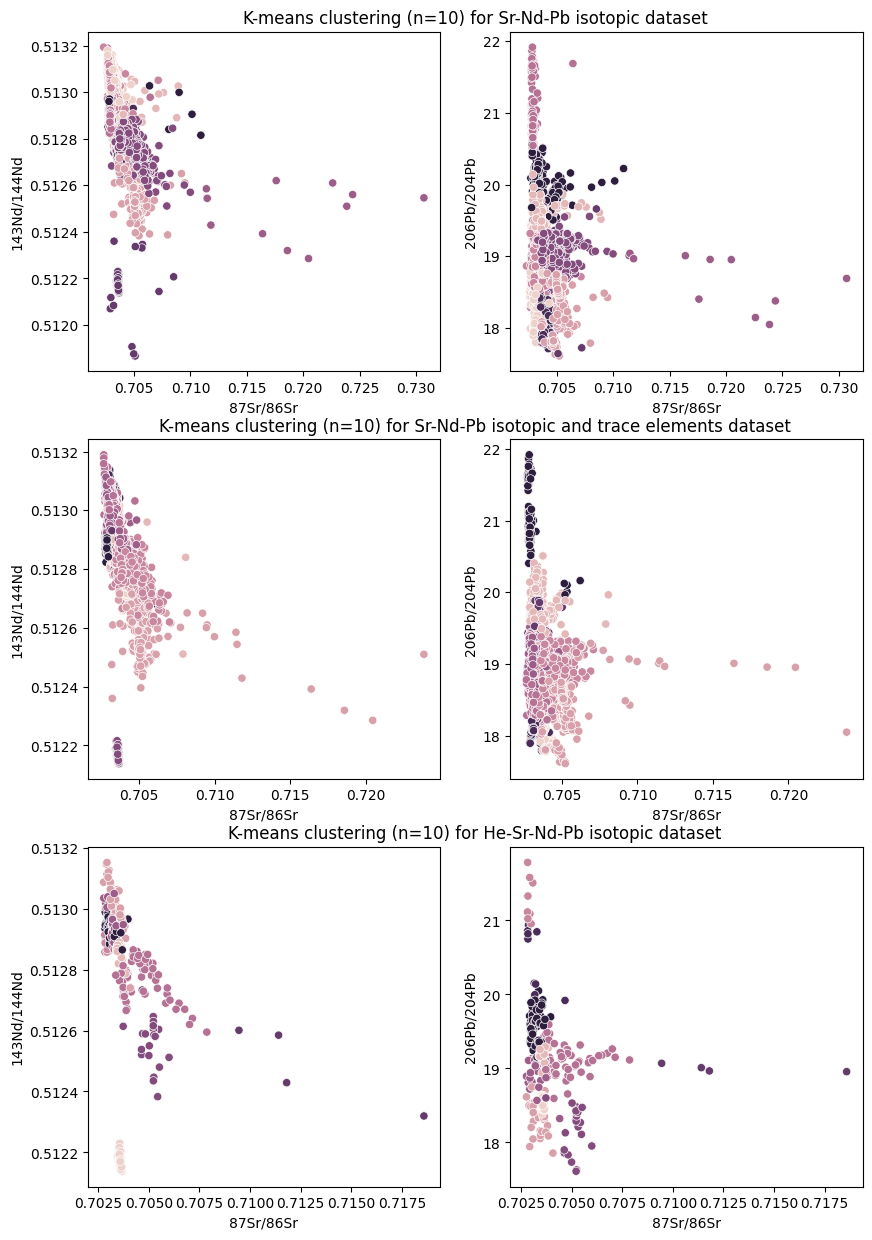

In [ ]:
# Initialize and fit models for each sub-dataset, n(clusters) = 10
kmeans_SrNdPb = KMeans(n_clusters=10, random_state=23, n_init='auto')
kmeans_SrNdPbTE = KMeans(n_clusters=10, random_state=23, n_init='auto')
kmeans_HeSrNdPb = KMeans(n_clusters=10, random_state=23, n_init='auto')

SrNdPb_kmeans = kmeans_SrNdPb.fit(SrNdPb_allhotspots_dataonly)
SrNdPbTE_kmeans = kmeans_SrNdPbTE.fit(SrNdPbTE_allhotspots_dataonly)
HeSrNdPb_kmeans = kmeans_HeSrNdPb.fit(HeSrNdPb_allhotspots_dataonly)

# Visualize results
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
ax1, ax2, ax3, ax4, ax5, ax6 = [axes[i, j] for i in range(3) for j in range(2)]

sns.scatterplot(x=SrNdPb_allhotspots['SR87_SR86'], y=SrNdPb_allhotspots['ND143_ND144'], hue=SrNdPb_kmeans.labels_, ax=ax1)
ax1.set_title('K-means clustering (n=10) for Sr-Nd-Pb isotopic dataset', x=1.1, y=1)
ax1.set_xlabel('87Sr/86Sr')
ax1.set_ylabel('143Nd/144Nd')
ax1.legend_.remove()

sns.scatterplot(x=SrNdPb_allhotspots['SR87_SR86'], y=SrNdPb_allhotspots['PB206_PB204'], hue=SrNdPb_kmeans.labels_, ax=ax2)
ax2.set_xlabel('87Sr/86Sr')
ax2.set_ylabel('206Pb/204Pb')
ax2.legend_.remove()

sns.scatterplot(x=SrNdPbTE_allhotspots['SR87_SR86'], y=SrNdPbTE_allhotspots['ND143_ND144'], hue=SrNdPbTE_kmeans.labels_, ax=ax3)
ax3.set_title('K-means clustering (n=10) for Sr-Nd-Pb isotopic and trace elements dataset', x=1.1, y=1)
ax3.set_xlabel('87Sr/86Sr')
ax3.set_ylabel('143Nd/144Nd')
ax3.legend_.remove()

sns.scatterplot(x=SrNdPbTE_allhotspots['SR87_SR86'], y=SrNdPbTE_allhotspots['PB206_PB204'], hue=SrNdPbTE_kmeans.labels_, ax=ax4)
ax4.set_xlabel('87Sr/86Sr')
ax4.set_ylabel('206Pb/204Pb')
ax4.legend_.remove()

sns.scatterplot(x=HeSrNdPb_allhotspots['SR87_SR86'], y=HeSrNdPb_allhotspots['ND143_ND144'], hue=HeSrNdPb_kmeans.labels_, ax=ax5)
ax5.set_title('K-means clustering (n=10) for He-Sr-Nd-Pb isotopic dataset', x=1.1, y=1)
ax5.set_xlabel('87Sr/86Sr')
ax5.set_ylabel('143Nd/144Nd')
ax5.legend_.remove()

sns.scatterplot(x=HeSrNdPb_allhotspots['SR87_SR86'], y=HeSrNdPb_allhotspots['PB206_PB204'], hue=HeSrNdPb_kmeans.labels_, ax=ax6)
ax6.set_xlabel('87Sr/86Sr')
ax6.set_ylabel('206Pb/204Pb')
ax6.legend_.remove()

plt.show()

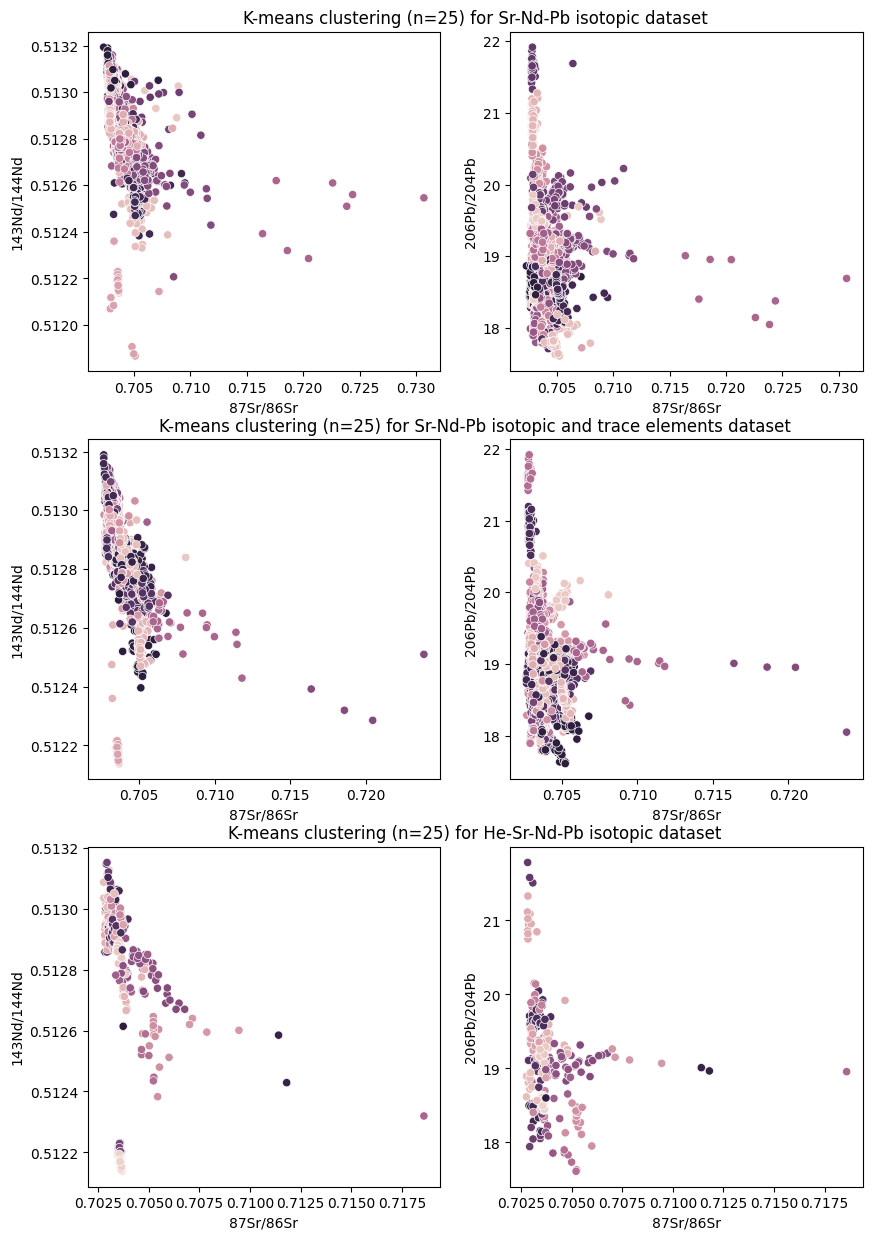

In [ ]:
# Initialize and fit models for each sub-dataset, n(clusters) = 25
kmeans_SrNdPb = KMeans(n_clusters=25, random_state=23, n_init='auto')
kmeans_SrNdPbTE = KMeans(n_clusters=25, random_state=23, n_init='auto')
kmeans_HeSrNdPb = KMeans(n_clusters=25, random_state=23, n_init='auto')

SrNdPb_kmeans = kmeans_SrNdPb.fit(SrNdPb_allhotspots_dataonly)
SrNdPbTE_kmeans = kmeans_SrNdPbTE.fit(SrNdPbTE_allhotspots_dataonly)
HeSrNdPb_kmeans = kmeans_HeSrNdPb.fit(HeSrNdPb_allhotspots_dataonly)

# Visualize results
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
ax1, ax2, ax3, ax4, ax5, ax6 = [axes[i, j] for i in range(3) for j in range(2)]

sns.scatterplot(x=SrNdPb_allhotspots['SR87_SR86'], y=SrNdPb_allhotspots['ND143_ND144'], hue=SrNdPb_kmeans.labels_, ax=ax1)
ax1.set_title('K-means clustering (n=25) for Sr-Nd-Pb isotopic dataset', x=1.1, y=1)
ax1.set_xlabel('87Sr/86Sr')
ax1.set_ylabel('143Nd/144Nd')
ax1.legend_.remove()

sns.scatterplot(x=SrNdPb_allhotspots['SR87_SR86'], y=SrNdPb_allhotspots['PB206_PB204'], hue=SrNdPb_kmeans.labels_, ax=ax2)
ax2.set_xlabel('87Sr/86Sr')
ax2.set_ylabel('206Pb/204Pb')
ax2.legend_.remove()

sns.scatterplot(x=SrNdPbTE_allhotspots['SR87_SR86'], y=SrNdPbTE_allhotspots['ND143_ND144'], hue=SrNdPbTE_kmeans.labels_, ax=ax3)
ax3.set_title('K-means clustering (n=25) for Sr-Nd-Pb isotopic and trace elements dataset', x=1.1, y=1)
ax3.set_xlabel('87Sr/86Sr')
ax3.set_ylabel('143Nd/144Nd')
ax3.legend_.remove()

sns.scatterplot(x=SrNdPbTE_allhotspots['SR87_SR86'], y=SrNdPbTE_allhotspots['PB206_PB204'], hue=SrNdPbTE_kmeans.labels_, ax=ax4)
ax4.set_xlabel('87Sr/86Sr')
ax4.set_ylabel('206Pb/204Pb')
ax4.legend_.remove()

sns.scatterplot(x=HeSrNdPb_allhotspots['SR87_SR86'], y=HeSrNdPb_allhotspots['ND143_ND144'], hue=HeSrNdPb_kmeans.labels_, ax=ax5)
ax5.set_title('K-means clustering (n=25) for He-Sr-Nd-Pb isotopic dataset', x=1.1, y=1)
ax5.set_xlabel('87Sr/86Sr')
ax5.set_ylabel('143Nd/144Nd')
ax5.legend_.remove()

sns.scatterplot(x=HeSrNdPb_allhotspots['SR87_SR86'], y=HeSrNdPb_allhotspots['PB206_PB204'], hue=HeSrNdPb_kmeans.labels_, ax=ax6)
ax6.set_xlabel('87Sr/86Sr')
ax6.set_ylabel('206Pb/204Pb')
ax6.legend_.remove()

plt.show()

For both higher-order clustering analyses, the results appear to increasingly break the samples first into more granular representations of the previously-recognized mantle components, then into groups that more closely represent individual hotspots. It is particularly notable that the convergence zone becomes more and more complex when more clusters are assigned, particularly in the sub-dataset including He isotopic compositions.

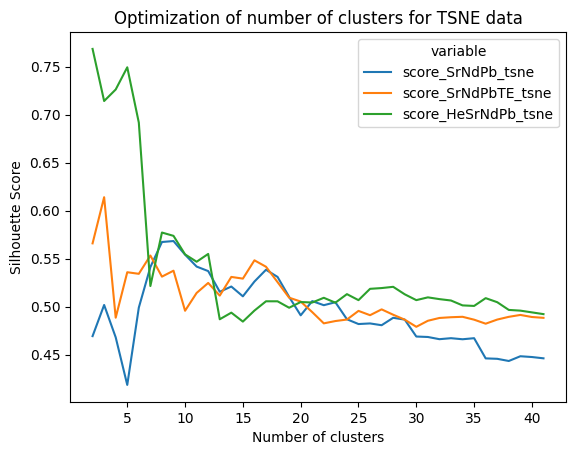

In [ ]:
# Perform k-means clustering analysis on t-SNE dimension-reduced data
# Optimize number of clusters for each sub-dataset
# Produce data-only DataFrames
tsne_result_SrNdPb_dataonly = tsne_result_SrNdPb_selhotspots.drop(columns=['hotspot'])
tsne_result_SrNdPbTE_dataonly = tsne_result_SrNdPbTE_selhotspots.drop(columns=['hotspot'])
tsne_result_HeSrNdPb_dataonly = tsne_result_HeSrNdPb_selhotspots.drop(columns=['hotspot'])

# Set testing range for clusters and create empty dataset
clusters = range(2, 42)
fits_SrNdPb_tsne = []
fits_SrNdPbTE_tsne = []
fits_HeSrNdPb_tsne = []
score_SrNdPb_tsne = []
score_SrNdPbTE_tsne = []
score_HeSrNdPb_tsne = []

# Initialize and fit clustering models
for cluster in clusters:
  kmeans_SrNdPb_tsne = KMeans(n_clusters=cluster, random_state=23, n_init='auto')
  kmeans_SrNdPbTE_tsne = KMeans(n_clusters=cluster, random_state=23, n_init='auto')
  kmeans_HeSrNdPb_tsne = KMeans(n_clusters=cluster, random_state=23, n_init='auto')

  SrNdPb_tsne_kmeans = kmeans_SrNdPb_tsne.fit(tsne_result_SrNdPb_dataonly)
  SrNdPbTE_tsne_kmeans = kmeans_SrNdPbTE_tsne.fit(tsne_result_SrNdPbTE_dataonly)
  HeSrNdPb_tsne_kmeans = kmeans_HeSrNdPb_tsne.fit(tsne_result_HeSrNdPb_dataonly)

  fits_SrNdPb_tsne.append(kmeans_SrNdPb_tsne)
  fits_SrNdPbTE_tsne.append(kmeans_SrNdPbTE_tsne)
  fits_HeSrNdPb_tsne.append(kmeans_HeSrNdPb_tsne)

  score_SrNdPb_tsne.append(silhouette_score(tsne_result_SrNdPb_dataonly, kmeans_SrNdPb_tsne.labels_, metric='euclidean'))
  score_SrNdPbTE_tsne.append(silhouette_score(tsne_result_SrNdPbTE_dataonly, kmeans_SrNdPbTE_tsne.labels_, metric='euclidean'))
  score_HeSrNdPb_tsne.append(silhouette_score(tsne_result_HeSrNdPb_dataonly, kmeans_HeSrNdPb_tsne.labels_, metric='euclidean'))

# Organize results
results = pd.DataFrame({'clusters': clusters,
                        'score_SrNdPb_tsne': score_SrNdPb_tsne,
                        'score_SrNdPbTE_tsne': score_SrNdPbTE_tsne,
                        'score_HeSrNdPb_tsne': score_HeSrNdPb_tsne})
results = pd.melt(results, ['clusters'])

# Produce plot
sns.lineplot(data=results, x='clusters', y='value', hue='variable').set(title='Optimization of number of clusters for TSNE data', xlabel='Number of clusters', ylabel='Silhouette Score')
plt.show()

Interestingly, there is no apparent score plateau for the Sr-Nd-Pb-TE and Sr-Nd-Pb sub-datasets. Only the dataset including He isotopic data has a clear score minimum starting at 8 clusters. Therefore, the following number of clusters will be considered:
- 5 clusters, reflecting the number of previously-recognized mantle components
- 7 clusters, reflecting the first minimum for the sub-database including He isotopic compositions
- 15 clusters, representing a point clearly on the minimum score plateau for the He-Sr-Nd-Pb sub-dataset

In each case, for simplicity only the 'selected hotspot' database from the t-SNE analysis will be used

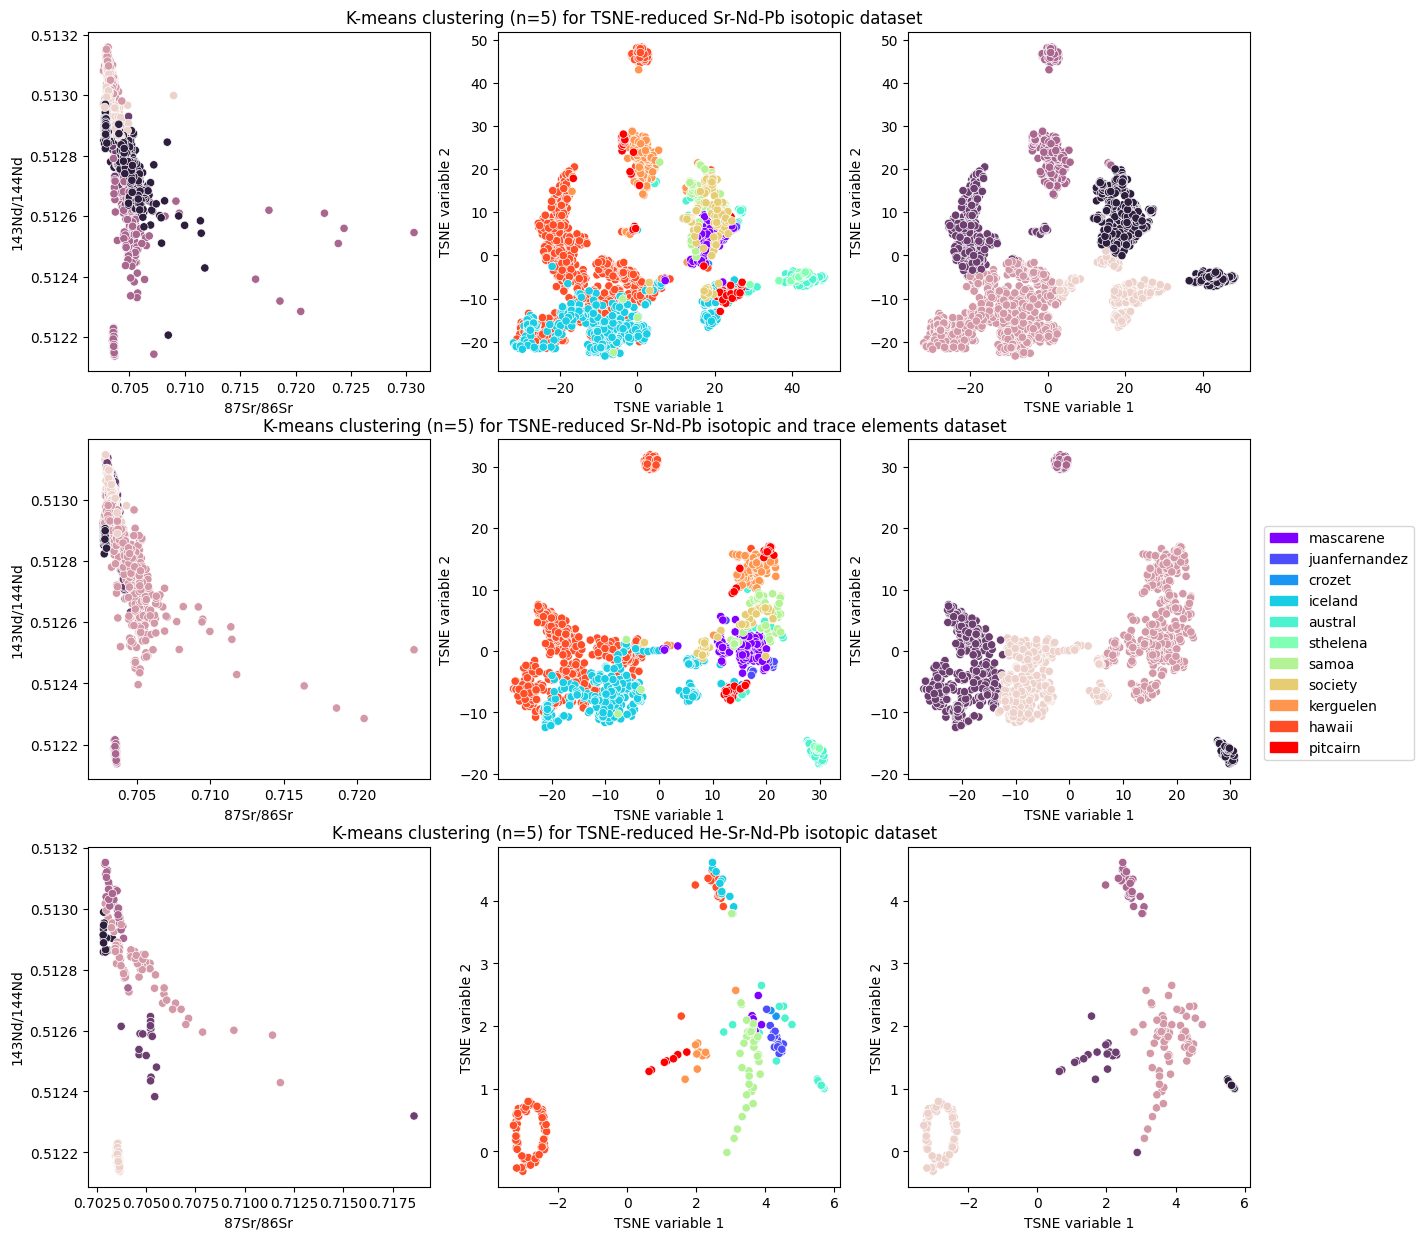

In [ ]:
# Make clustering model for n=5 clusters
# Create data-only DataFrames for selected hotspots
tsne_result_SrNdPb_selhotspots_dataonly = tsne_result_SrNdPb_selhotspots.drop(columns=['hotspot'])
tsne_result_SrNdPbTE_selhotspots_dataonly = tsne_result_SrNdPbTE_selhotspots.drop(columns=['hotspot'])
tsne_result_HeSrNdPb_selhotspots_dataonly = tsne_result_HeSrNdPb_selhotspots.drop(columns=['hotspot'])

# Initialize and fit models for each sub-dataset, n(clusters) = 5
kmeans_SrNdPb_selhotspots_tsne = KMeans(n_clusters=5, random_state=23, n_init='auto')
kmeans_SrNdPbTE_selhotspots_tsne = KMeans(n_clusters=5, random_state=23, n_init='auto')
kmeans_HeSrNdPb_selhotspots_tsne = KMeans(n_clusters=5, random_state=23, n_init='auto')

SrNdPb_selhotspots_tsne_kmeans = kmeans_SrNdPb_selhotspots_tsne.fit(tsne_result_SrNdPb_selhotspots_dataonly)
SrNdPbTE_selhotspots_tsne_kmeans = kmeans_SrNdPbTE_selhotspots_tsne.fit(tsne_result_SrNdPbTE_selhotspots_dataonly)
HeSrNdPb_selhotspots_tsne_kmeans = kmeans_HeSrNdPb_selhotspots_tsne.fit(tsne_result_HeSrNdPb_selhotspots_dataonly)

# Visualize results

# Create color array for per-hotspot results
n = len(selhotspots)
colors = cm.rainbow(np.linspace(0,1,n))
color_dict = {selhotspots[i]: colors[i] for i in range(n)}
patches = []
for hotspot in selhotspots:
  patches.append(mpatches.Patch(color=color_dict[hotspot], label=hotspot))


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = [axes[i, j] for i in range(3) for j in range(3)]

sns.scatterplot(x=SrNdPb_selhotspots['SR87_SR86'], y=SrNdPb_selhotspots['ND143_ND144'], hue=SrNdPb_selhotspots_tsne_kmeans.labels_, ax=ax1)
ax1.set_title('K-means clustering (n=5) for TSNE-reduced Sr-Nd-Pb isotopic dataset', x=1.6, y=1)
ax1.set_xlabel('87Sr/86Sr')
ax1.set_ylabel('143Nd/144Nd')
ax1.legend_.remove()

sns.scatterplot(x=tsne_result_SrNdPb_selhotspots['tsne_1'], y=tsne_result_SrNdPb_selhotspots['tsne_2'], hue=tsne_result_SrNdPb_selhotspots['hotspot'], palette=color_dict, ax=ax2)
ax2.set_xlabel('TSNE variable 1')
ax2.set_ylabel('TSNE variable 2')
ax2.legend_.remove()

sns.scatterplot(x=tsne_result_SrNdPb_selhotspots['tsne_1'], y=tsne_result_SrNdPb_selhotspots['tsne_2'], hue=SrNdPb_selhotspots_tsne_kmeans.labels_, ax=ax3)
ax3.set_xlabel('TSNE variable 1')
ax3.set_ylabel('TSNE variable 2')
ax3.legend_.remove()


sns.scatterplot(x=SrNdPbTE_selhotspots['SR87_SR86'], y=SrNdPbTE_selhotspots['ND143_ND144'], hue=SrNdPbTE_selhotspots_tsne_kmeans.labels_, ax=ax4)
ax4.set_title('K-means clustering (n=5) for TSNE-reduced Sr-Nd-Pb isotopic and trace elements dataset', x=1.6, y=1)
ax4.set_xlabel('87Sr/86Sr')
ax4.set_ylabel('143Nd/144Nd')
ax4.legend_.remove()

sns.scatterplot(x=tsne_result_SrNdPbTE_selhotspots['tsne_1'], y=tsne_result_SrNdPbTE_selhotspots['tsne_2'], hue=tsne_result_SrNdPbTE_selhotspots['hotspot'], palette=color_dict, ax=ax5)
ax5.set_xlabel('TSNE variable 1')
ax5.set_ylabel('TSNE variable 2')
ax5.legend_.remove()

sns.scatterplot(x=tsne_result_SrNdPbTE_selhotspots['tsne_1'], y=tsne_result_SrNdPbTE_selhotspots['tsne_2'], hue=SrNdPbTE_selhotspots_tsne_kmeans.labels_, ax=ax6)
ax6.set_xlabel('TSNE variable 1')
ax6.set_ylabel('TSNE variable 2')
ax6.legend_.remove()


sns.scatterplot(x=HeSrNdPb_selhotspots['SR87_SR86'], y=HeSrNdPb_selhotspots['ND143_ND144'], hue=HeSrNdPb_selhotspots_tsne_kmeans.labels_, ax=ax7)
ax7.set_title('K-means clustering (n=5) for TSNE-reduced He-Sr-Nd-Pb isotopic dataset', x=1.6, y=1)
ax7.set_xlabel('87Sr/86Sr')
ax7.set_ylabel('143Nd/144Nd')
ax7.legend_.remove()

sns.scatterplot(x=tsne_result_HeSrNdPb_selhotspots['tsne_1'], y=tsne_result_HeSrNdPb_selhotspots['tsne_2'], hue=tsne_result_HeSrNdPb_selhotspots['hotspot'], palette=color_dict, ax=ax8)
ax8.set_xlabel('TSNE variable 1')
ax8.set_ylabel('TSNE variable 2')
ax8.legend_.remove()

sns.scatterplot(x=tsne_result_HeSrNdPb_selhotspots['tsne_1'], y=tsne_result_HeSrNdPb_selhotspots['tsne_2'], hue=HeSrNdPb_selhotspots_tsne_kmeans.labels_, ax=ax9)
ax9.set_xlabel('TSNE variable 1')
ax9.set_ylabel('TSNE variable 2')
ax9.legend_.remove()

# Add legend & show plot
plt.legend(handles=patches, loc='right', bbox_to_anchor=(1.5, 1.6))
plt.show()


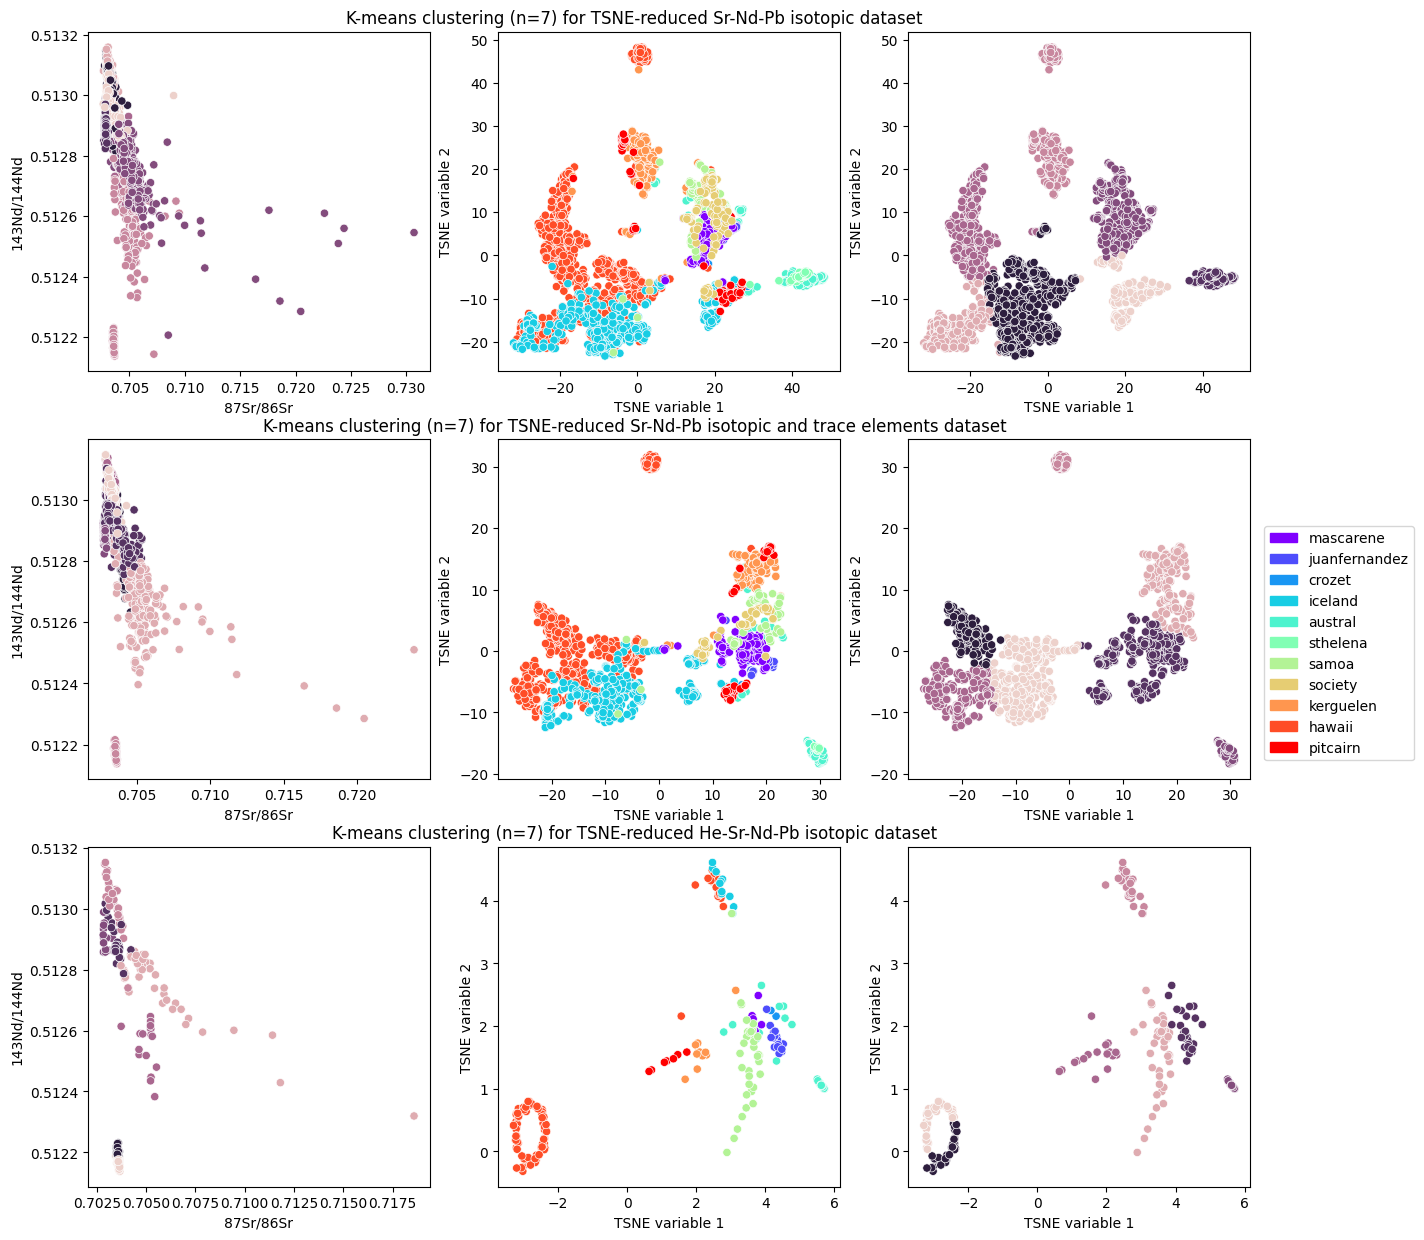

In [ ]:
# Make clustering model for n=7 clusters
# Create data-only DataFrames for selected hotspots
tsne_result_SrNdPb_selhotspots_dataonly = tsne_result_SrNdPb_selhotspots.drop(columns=['hotspot'])
tsne_result_SrNdPbTE_selhotspots_dataonly = tsne_result_SrNdPbTE_selhotspots.drop(columns=['hotspot'])
tsne_result_HeSrNdPb_selhotspots_dataonly = tsne_result_HeSrNdPb_selhotspots.drop(columns=['hotspot'])

# Initialize and fit models for each sub-dataset, n(clusters) = 7
kmeans_SrNdPb_selhotspots_tsne = KMeans(n_clusters=7, random_state=23, n_init='auto')
kmeans_SrNdPbTE_selhotspots_tsne = KMeans(n_clusters=7, random_state=23, n_init='auto')
kmeans_HeSrNdPb_selhotspots_tsne = KMeans(n_clusters=7, random_state=23, n_init='auto')

SrNdPb_selhotspots_tsne_kmeans = kmeans_SrNdPb_selhotspots_tsne.fit(tsne_result_SrNdPb_selhotspots_dataonly)
SrNdPbTE_selhotspots_tsne_kmeans = kmeans_SrNdPbTE_selhotspots_tsne.fit(tsne_result_SrNdPbTE_selhotspots_dataonly)
HeSrNdPb_selhotspots_tsne_kmeans = kmeans_HeSrNdPb_selhotspots_tsne.fit(tsne_result_HeSrNdPb_selhotspots_dataonly)

# Visualize results

# Create color array for per-hotspot results
n = len(selhotspots)
colors = cm.rainbow(np.linspace(0,1,n))
color_dict = {selhotspots[i]: colors[i] for i in range(n)}
patches = []
for hotspot in selhotspots:
  patches.append(mpatches.Patch(color=color_dict[hotspot], label=hotspot))


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = [axes[i, j] for i in range(3) for j in range(3)]

sns.scatterplot(x=SrNdPb_selhotspots['SR87_SR86'], y=SrNdPb_selhotspots['ND143_ND144'], hue=SrNdPb_selhotspots_tsne_kmeans.labels_, ax=ax1)
ax1.set_title('K-means clustering (n=7) for TSNE-reduced Sr-Nd-Pb isotopic dataset', x=1.6, y=1)
ax1.set_xlabel('87Sr/86Sr')
ax1.set_ylabel('143Nd/144Nd')
ax1.legend_.remove()

sns.scatterplot(x=tsne_result_SrNdPb_selhotspots['tsne_1'], y=tsne_result_SrNdPb_selhotspots['tsne_2'], hue=tsne_result_SrNdPb_selhotspots['hotspot'], palette=color_dict, ax=ax2)
ax2.set_xlabel('TSNE variable 1')
ax2.set_ylabel('TSNE variable 2')
ax2.legend_.remove()

sns.scatterplot(x=tsne_result_SrNdPb_selhotspots['tsne_1'], y=tsne_result_SrNdPb_selhotspots['tsne_2'], hue=SrNdPb_selhotspots_tsne_kmeans.labels_, ax=ax3)
ax3.set_xlabel('TSNE variable 1')
ax3.set_ylabel('TSNE variable 2')
ax3.legend_.remove()


sns.scatterplot(x=SrNdPbTE_selhotspots['SR87_SR86'], y=SrNdPbTE_selhotspots['ND143_ND144'], hue=SrNdPbTE_selhotspots_tsne_kmeans.labels_, ax=ax4)
ax4.set_title('K-means clustering (n=7) for TSNE-reduced Sr-Nd-Pb isotopic and trace elements dataset', x=1.6, y=1)
ax4.set_xlabel('87Sr/86Sr')
ax4.set_ylabel('143Nd/144Nd')
ax4.legend_.remove()

sns.scatterplot(x=tsne_result_SrNdPbTE_selhotspots['tsne_1'], y=tsne_result_SrNdPbTE_selhotspots['tsne_2'], hue=tsne_result_SrNdPbTE_selhotspots['hotspot'], palette=color_dict, ax=ax5)
ax5.set_xlabel('TSNE variable 1')
ax5.set_ylabel('TSNE variable 2')
ax5.legend_.remove()

sns.scatterplot(x=tsne_result_SrNdPbTE_selhotspots['tsne_1'], y=tsne_result_SrNdPbTE_selhotspots['tsne_2'], hue=SrNdPbTE_selhotspots_tsne_kmeans.labels_, ax=ax6)
ax6.set_xlabel('TSNE variable 1')
ax6.set_ylabel('TSNE variable 2')
ax6.legend_.remove()


sns.scatterplot(x=HeSrNdPb_selhotspots['SR87_SR86'], y=HeSrNdPb_selhotspots['ND143_ND144'], hue=HeSrNdPb_selhotspots_tsne_kmeans.labels_, ax=ax7)
ax7.set_title('K-means clustering (n=7) for TSNE-reduced He-Sr-Nd-Pb isotopic dataset', x=1.6, y=1)
ax7.set_xlabel('87Sr/86Sr')
ax7.set_ylabel('143Nd/144Nd')
ax7.legend_.remove()

sns.scatterplot(x=tsne_result_HeSrNdPb_selhotspots['tsne_1'], y=tsne_result_HeSrNdPb_selhotspots['tsne_2'], hue=tsne_result_HeSrNdPb_selhotspots['hotspot'], palette=color_dict, ax=ax8)
ax8.set_xlabel('TSNE variable 1')
ax8.set_ylabel('TSNE variable 2')
ax8.legend_.remove()

sns.scatterplot(x=tsne_result_HeSrNdPb_selhotspots['tsne_1'], y=tsne_result_HeSrNdPb_selhotspots['tsne_2'], hue=HeSrNdPb_selhotspots_tsne_kmeans.labels_, ax=ax9)
ax9.set_xlabel('TSNE variable 1')
ax9.set_ylabel('TSNE variable 2')
ax9.legend_.remove()

# Add legend & show plot
plt.legend(handles=patches, loc='right', bbox_to_anchor=(1.5, 1.6))
plt.show()


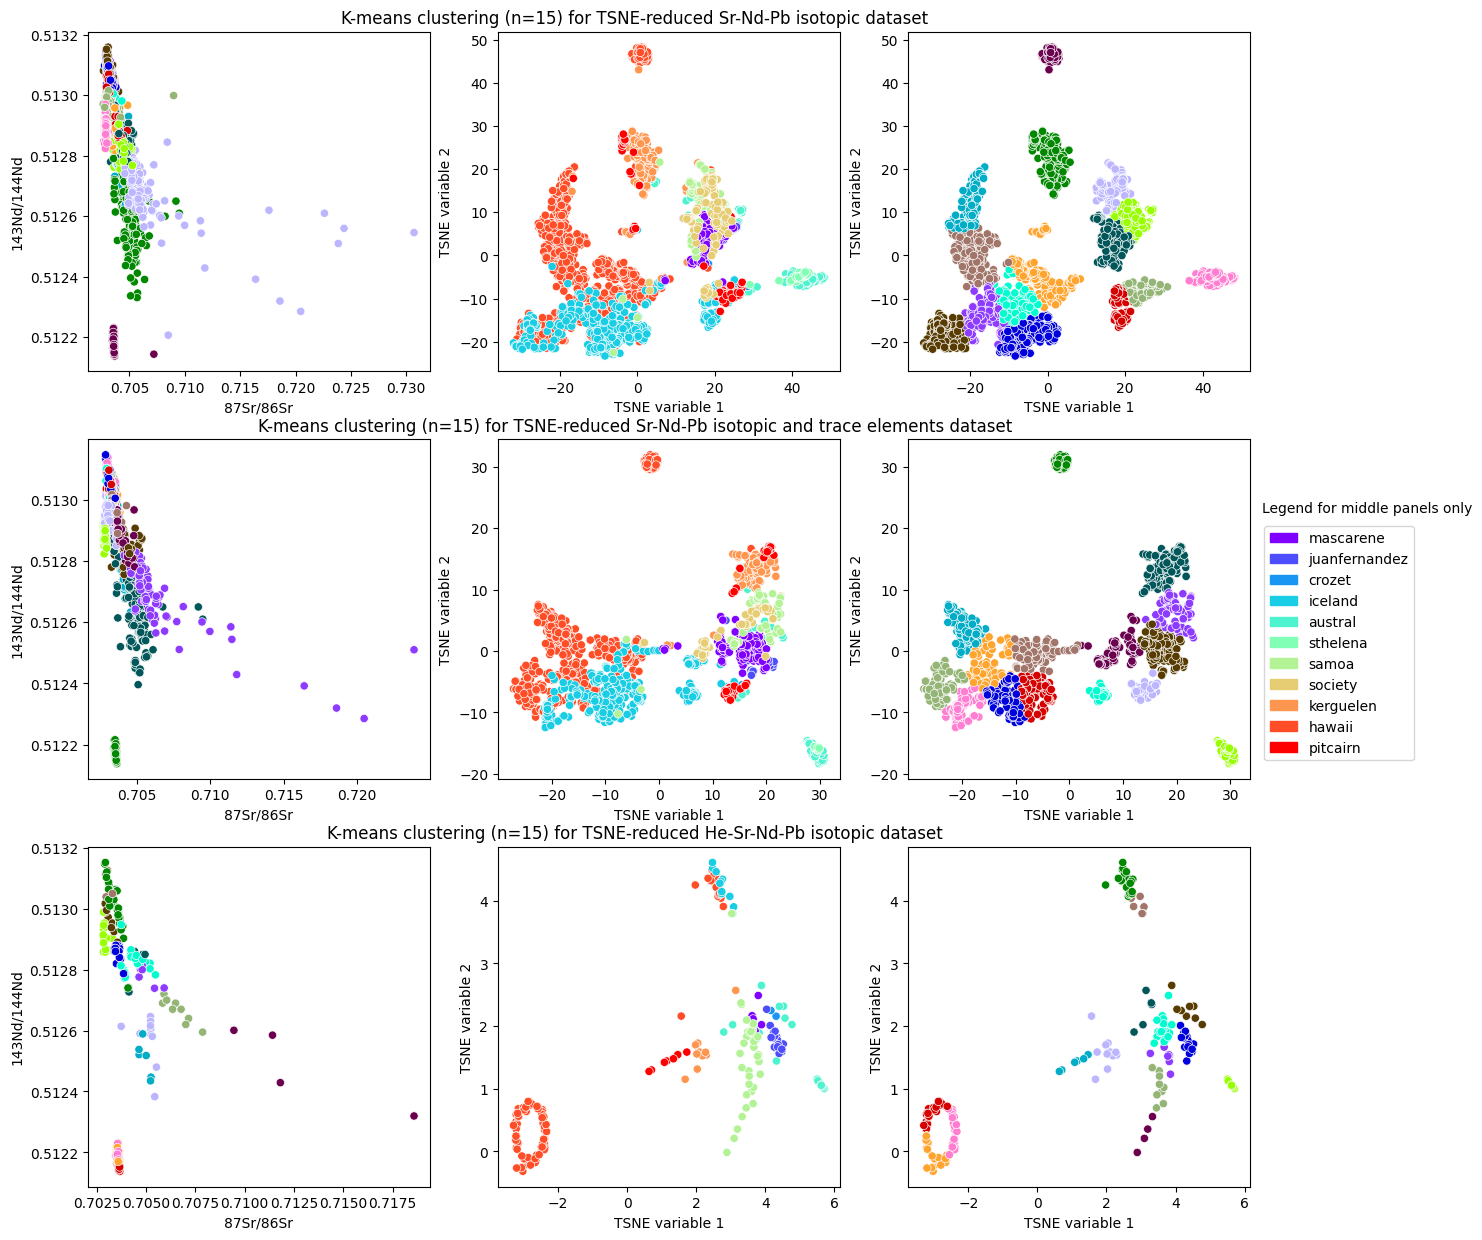

In [ ]:
# Make clustering model for n=15 clusters
# Create data-only DataFrames for selected hotspots
tsne_result_SrNdPb_selhotspots_dataonly = tsne_result_SrNdPb_selhotspots.drop(columns=['hotspot'])
tsne_result_SrNdPbTE_selhotspots_dataonly = tsne_result_SrNdPbTE_selhotspots.drop(columns=['hotspot'])
tsne_result_HeSrNdPb_selhotspots_dataonly = tsne_result_HeSrNdPb_selhotspots.drop(columns=['hotspot'])

# Initialize and fit models for each sub-dataset, n(clusters) = 15
kmeans_SrNdPb_selhotspots_tsne = KMeans(n_clusters=15, random_state=23, n_init='auto')
kmeans_SrNdPbTE_selhotspots_tsne = KMeans(n_clusters=15, random_state=23, n_init='auto')
kmeans_HeSrNdPb_selhotspots_tsne = KMeans(n_clusters=15, random_state=23, n_init='auto')

SrNdPb_selhotspots_tsne_kmeans = kmeans_SrNdPb_selhotspots_tsne.fit(tsne_result_SrNdPb_selhotspots_dataonly)
SrNdPbTE_selhotspots_tsne_kmeans = kmeans_SrNdPbTE_selhotspots_tsne.fit(tsne_result_SrNdPbTE_selhotspots_dataonly)
HeSrNdPb_selhotspots_tsne_kmeans = kmeans_HeSrNdPb_selhotspots_tsne.fit(tsne_result_HeSrNdPb_selhotspots_dataonly)

# Create lists of labels
SrNdPb_selhotspots_tsne_kmeans_labels = pd.DataFrame({'tsne_1': tsne_result_SrNdPb_selhotspots['tsne_1'],
                                                      'tsne_2': tsne_result_SrNdPb_selhotspots['tsne_2'],
                                                      'hotspot': tsne_result_SrNdPb_selhotspots['hotspot'],
                                                      'label': SrNdPb_selhotspots_tsne_kmeans.labels_})
SrNdPbTE_selhotspots_tsne_kmeans_labels = pd.DataFrame({'tsne_1': tsne_result_SrNdPbTE_selhotspots['tsne_1'],
                                                        'tsne_2': tsne_result_SrNdPbTE_selhotspots['tsne_2'],
                                                        'hotspot': tsne_result_SrNdPbTE_selhotspots['hotspot'],
                                                        'label': SrNdPbTE_selhotspots_tsne_kmeans.labels_})
HeSrNdPb_selhotspots_tsne_kmeans_labels = pd.DataFrame({'tsne_1': tsne_result_HeSrNdPb_selhotspots['tsne_1'],
                                                        'tsne_2': tsne_result_HeSrNdPb_selhotspots['tsne_2'],
                                                        'hotspot': tsne_result_HeSrNdPb_selhotspots['hotspot'],
                                                        'label': HeSrNdPb_selhotspots_tsne_kmeans.labels_})

# Visualize results

# Create color arrays for per-hotspot results
import colorcet as cc
n = len(selhotspots)
colors = cm.rainbow(np.linspace(0,1,n))
color_dict = {selhotspots[i]: colors[i] for i in range(n)}
patches = []
for hotspot in selhotspots:
  patches.append(mpatches.Patch(color=color_dict[hotspot], label=hotspot))
palette = sns.color_palette(cc.glasbey, n_colors=15)


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = [axes[i, j] for i in range(3) for j in range(3)]

sns.scatterplot(x=SrNdPb_selhotspots['SR87_SR86'], y=SrNdPb_selhotspots['ND143_ND144'], hue=SrNdPb_selhotspots_tsne_kmeans.labels_, palette=palette, ax=ax1)
ax1.set_title('K-means clustering (n=15) for TSNE-reduced Sr-Nd-Pb isotopic dataset', x=1.6, y=1)
ax1.set_xlabel('87Sr/86Sr')
ax1.set_ylabel('143Nd/144Nd')
ax1.legend_.remove()

sns.scatterplot(x=tsne_result_SrNdPb_selhotspots['tsne_1'], y=tsne_result_SrNdPb_selhotspots['tsne_2'], hue=tsne_result_SrNdPb_selhotspots['hotspot'], palette=color_dict, ax=ax2)
ax2.set_xlabel('TSNE variable 1')
ax2.set_ylabel('TSNE variable 2')
ax2.legend_.remove()

sns.scatterplot(x=tsne_result_SrNdPb_selhotspots['tsne_1'], y=tsne_result_SrNdPb_selhotspots['tsne_2'], hue=SrNdPb_selhotspots_tsne_kmeans.labels_, palette=palette, ax=ax3)
ax3.set_xlabel('TSNE variable 1')
ax3.set_ylabel('TSNE variable 2')
ax3.legend_.remove()


sns.scatterplot(x=SrNdPbTE_selhotspots['SR87_SR86'], y=SrNdPbTE_selhotspots['ND143_ND144'], hue=SrNdPbTE_selhotspots_tsne_kmeans.labels_, palette=palette, ax=ax4)
ax4.set_title('K-means clustering (n=15) for TSNE-reduced Sr-Nd-Pb isotopic and trace elements dataset', x=1.6, y=1)
ax4.set_xlabel('87Sr/86Sr')
ax4.set_ylabel('143Nd/144Nd')
ax4.legend_.remove()

sns.scatterplot(x=tsne_result_SrNdPbTE_selhotspots['tsne_1'], y=tsne_result_SrNdPbTE_selhotspots['tsne_2'], hue=tsne_result_SrNdPbTE_selhotspots['hotspot'], palette=color_dict, ax=ax5)
ax5.set_xlabel('TSNE variable 1')
ax5.set_ylabel('TSNE variable 2')
ax5.legend_.remove()

sns.scatterplot(x=tsne_result_SrNdPbTE_selhotspots['tsne_1'], y=tsne_result_SrNdPbTE_selhotspots['tsne_2'], hue=SrNdPbTE_selhotspots_tsne_kmeans.labels_, palette=palette, ax=ax6)
ax6.set_xlabel('TSNE variable 1')
ax6.set_ylabel('TSNE variable 2')
ax6.legend_.remove()


sns.scatterplot(x=HeSrNdPb_selhotspots['SR87_SR86'], y=HeSrNdPb_selhotspots['ND143_ND144'], hue=HeSrNdPb_selhotspots_tsne_kmeans.labels_, palette=palette, ax=ax7)
ax7.set_title('K-means clustering (n=15) for TSNE-reduced He-Sr-Nd-Pb isotopic dataset', x=1.6, y=1)
ax7.set_xlabel('87Sr/86Sr')
ax7.set_ylabel('143Nd/144Nd')
ax7.legend_.remove()

sns.scatterplot(x=tsne_result_HeSrNdPb_selhotspots['tsne_1'], y=tsne_result_HeSrNdPb_selhotspots['tsne_2'], hue=tsne_result_HeSrNdPb_selhotspots['hotspot'], palette=color_dict, ax=ax8)
ax8.set_xlabel('TSNE variable 1')
ax8.set_ylabel('TSNE variable 2')
ax8.legend_.remove()

sns.scatterplot(x=tsne_result_HeSrNdPb_selhotspots['tsne_1'], y=tsne_result_HeSrNdPb_selhotspots['tsne_2'], hue=HeSrNdPb_selhotspots_tsne_kmeans.labels_, palette=palette, ax=ax9)
ax9.set_xlabel('TSNE variable 1')
ax9.set_ylabel('TSNE variable 2')
ax9.legend_.remove()

# Add legend & show plot
plt.legend(handles=patches, loc='right', bbox_to_anchor=(1.5, 1.6))
plt.text(s='Legend for middle panels only', x=6.5, y=10.2)
plt.show()


The t-SNE reduced data also tend to form clusters that reflect previously-recognized mantle components when the number of clusters is low (n=5). However, there are some notable details:
- The Sr-Nd-Pb isotopic sub-dataset groups all EM-type lavas together, produces two groups that roughly overlap the FOZO region, and has a distinct HIMU cluster; by contrast, the Sr-Nd-Pb and trace elements sub-dataset splits the EM-type lavas into two elongated groups that each contain some FOZO-type lava samples and then has a separate cluster representing other FOZO-type lavas
- The He-Sr-Nd-Pb isotopic sub-dataset produces the clearest cluster distinctions, which tend to be paired hotspot groups: (Kerguelen + Pitcairn, both EM tending EM-1), (Iceland + some Hawaii), (Austral, representing the strongest HIMU-type lavas), (Mascarene + Juan Fernandez + Samoa lavas, plus some lavas from other hotspots, representing mostly FOZO-type samples but also including the EM-2 component of Samoa), (remainder of Hawai'i samples)

Adding additional clusters further divides the larger clusters, but mostly in ways that escape a clear interpretation. For example, the ring representing the "remainder of Hawai'i samples" in the He-Sr-Nd-Pb isotopic dataset is split into three clusters, but it is uncelar what this would mean.

From these analyses, I postulate that the most effective filter is produced by a higher-n analysis of the t-SNE reduced Sr-Nd-Pb isotopic dataset. It produces a sub-division granular enough to clearly exclude clusters assoicated with non-FOZO components and produce a more FOZO-like database

Next, I use this clustering as a filter to identify the FOZO-type samples from the main dataset to start a more detailed analysis.

# **5. Isolation of FOZO-like sample compositions using k-means clusters**

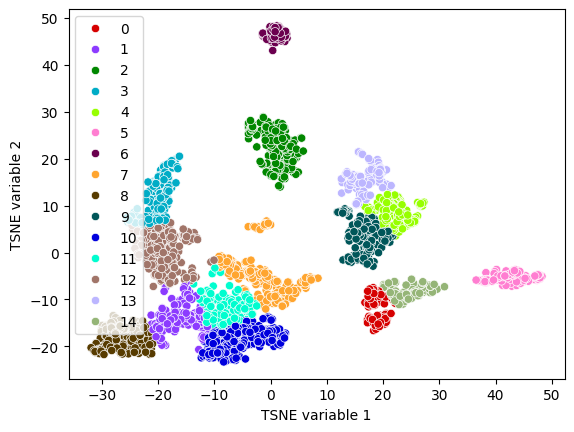

In [ ]:
# Filter main Sr-Nd-Pb dataset based on clustering
# Identify the indices of clusters to be filtered in
sns.scatterplot(x=tsne_result_SrNdPb_selhotspots['tsne_1'], y=tsne_result_SrNdPb_selhotspots['tsne_2'], hue=SrNdPb_selhotspots_tsne_kmeans.labels_, palette=palette)
plt.xlabel('TSNE variable 1')
plt.ylabel('TSNE variable 2')
plt.legend()
plt.show()

Clusters to exclude: 2 (EM-1), 5 (HIMU), 6 (Enriched Loa), 8 (DM), 13 (EM-2)

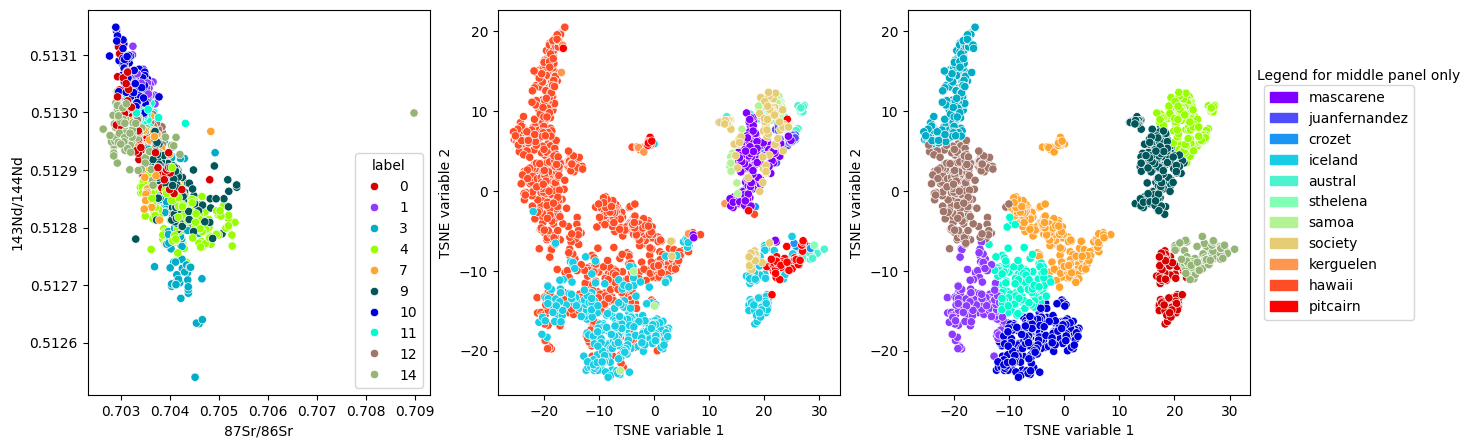

In [ ]:
# Replot to check filtering
# Filter clustering results
tsne_result_SrNdPb_selhotspots_filter1 = SrNdPb_selhotspots_tsne_kmeans_labels[SrNdPb_selhotspots_tsne_kmeans_labels['label'].isin([0, 1, 3, 4, 7, 9, 10, 11, 12, 14])].copy()
tsne_result_SrNdPbTE_selhotspots_filter1 = SrNdPbTE_selhotspots_tsne_kmeans_labels[SrNdPbTE_selhotspots_tsne_kmeans_labels['label'].isin([0, 1, 3, 4, 7, 9, 10, 11, 12, 14])].copy()
tsne_result_HeSrNdPb_selhotspots_filter1 = HeSrNdPb_selhotspots_tsne_kmeans_labels[HeSrNdPb_selhotspots_tsne_kmeans_labels['label'].isin([0, 1, 3, 4, 7, 9, 10, 11, 12, 14])].copy()

# Filter Sr-Nd-Pb sub-datasets
SrNdPb_selhotspots_dataonly_wcluster = SrNdPb_selhotspots_dataonly.copy()
SrNdPb_selhotspots_wcluster = SrNdPb_selhotspots.copy()

SrNdPb_selhotspots_dataonly_wcluster['label'] = SrNdPb_selhotspots_tsne_kmeans_labels['label']
SrNdPb_selhotspots_wcluster['label'] = SrNdPb_selhotspots_tsne_kmeans_labels['label']

SrNdPb_selhotspots_dataonly_filter1 = SrNdPb_selhotspots_dataonly_wcluster[SrNdPb_selhotspots_dataonly_wcluster['label'].isin([0, 1, 3, 4, 7, 9, 10, 11, 12, 14])].drop(columns=['label'])
SrNdPb_selhotspots_filter1 = SrNdPb_selhotspots_wcluster[SrNdPb_selhotspots_wcluster['label'].isin([0, 1, 3, 4, 7, 9, 10, 11, 12, 14])]

# Visualize filtered data
palette_filter1 = [palette[i] for i in [0, 1, 3, 4, 7, 9, 10, 11, 12, 14]]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.scatterplot(x=SrNdPb_selhotspots_filter1['SR87_SR86'], y=SrNdPb_selhotspots_filter1['ND143_ND144'], hue=SrNdPb_selhotspots_filter1['label'], palette=palette_filter1, ax=ax1)
ax1.set_xlabel('87Sr/86Sr')
ax1.set_ylabel('143Nd/144Nd')

sns.scatterplot(x=tsne_result_SrNdPb_selhotspots_filter1['tsne_1'], y=tsne_result_SrNdPb_selhotspots_filter1['tsne_2'], hue=tsne_result_SrNdPb_selhotspots_filter1['hotspot'], palette=color_dict, ax=ax2)
ax2.set_xlabel('TSNE variable 1')
ax2.set_ylabel('TSNE variable 2')
ax2.legend_.remove()

sns.scatterplot(x=tsne_result_SrNdPb_selhotspots_filter1['tsne_1'], y=tsne_result_SrNdPb_selhotspots_filter1['tsne_2'], hue=tsne_result_SrNdPb_selhotspots_filter1['label'], palette=palette_filter1, ax=ax3)
ax3.set_xlabel('TSNE variable 1')
ax3.set_ylabel('TSNE variable 2')
ax3.legend_.remove()

plt.legend(handles=patches, loc='right', bbox_to_anchor=(1.5, 0.5))
plt.text(s='Legend for middle panel only', x=35, y=14)
plt.show()

Further clusters to remove: 3 (EM component of Hawai'i), 1 & 10 (DM components of Iceland and Hawai'i). Cluster 0 left in despite containing some very depleted signatures because it also contains many FOZO-like signatures.

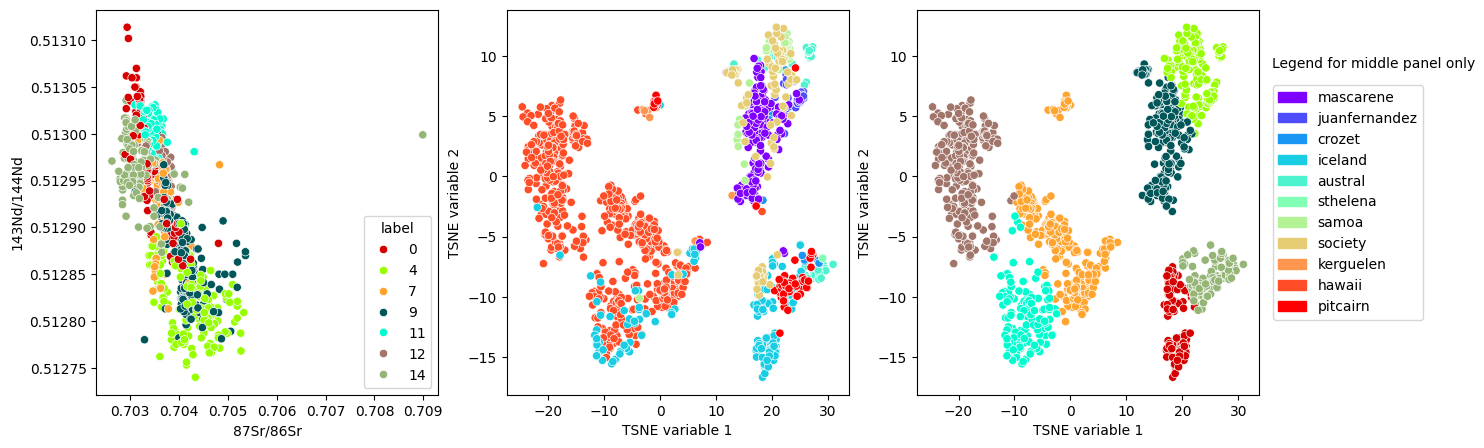

In [ ]:
# Replot to check new filtering
# 2nd pass filter of clustering results
tsne_result_SrNdPb_selhotspots_filter2 = SrNdPb_selhotspots_tsne_kmeans_labels[SrNdPb_selhotspots_tsne_kmeans_labels['label'].isin([0, 4, 7, 9, 11, 12, 14])].copy()
tsne_result_SrNdPbTE_selhotspots_filter2 = SrNdPbTE_selhotspots_tsne_kmeans_labels[SrNdPbTE_selhotspots_tsne_kmeans_labels['label'].isin([0, 4, 7, 9, 11, 12, 14])].copy()
tsne_result_HeSrNdPb_selhotspots_filter2 = HeSrNdPb_selhotspots_tsne_kmeans_labels[HeSrNdPb_selhotspots_tsne_kmeans_labels['label'].isin([0, 4, 7, 9, 11, 12, 14])].copy()

# Filter Sr-Nd-Pb sub-datasets
SrNdPb_selhotspots_dataonly_filter2 = SrNdPb_selhotspots_dataonly_wcluster[SrNdPb_selhotspots_dataonly_wcluster['label'].isin([0, 4, 7, 9, 11, 12, 14])].drop(columns=['label'])
SrNdPb_selhotspots_filter2 = SrNdPb_selhotspots_wcluster[SrNdPb_selhotspots_wcluster['label'].isin([0, 4, 7, 9, 11, 12, 14])]

# Visualize filtered data
palette_filter2 = [palette[i] for i in [0, 4, 7, 9, 11, 12, 14]]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.scatterplot(x=SrNdPb_selhotspots_filter2['SR87_SR86'], y=SrNdPb_selhotspots_filter2['ND143_ND144'], hue=SrNdPb_selhotspots_filter2['label'], palette=palette_filter2, ax=ax1)
ax1.set_xlabel('87Sr/86Sr')
ax1.set_ylabel('143Nd/144Nd')

sns.scatterplot(x=tsne_result_SrNdPb_selhotspots_filter2['tsne_1'], y=tsne_result_SrNdPb_selhotspots_filter2['tsne_2'], hue=tsne_result_SrNdPb_selhotspots_filter2['hotspot'], palette=color_dict, ax=ax2)
ax2.set_xlabel('TSNE variable 1')
ax2.set_ylabel('TSNE variable 2')
ax2.legend_.remove()

sns.scatterplot(x=tsne_result_SrNdPb_selhotspots_filter2['tsne_1'], y=tsne_result_SrNdPb_selhotspots_filter2['tsne_2'], hue=tsne_result_SrNdPb_selhotspots_filter2['label'], palette=palette_filter2, ax=ax3)
ax3.set_xlabel('TSNE variable 1')
ax3.set_ylabel('TSNE variable 2')
ax3.legend_.remove()

plt.legend(handles=patches, loc='right', bbox_to_anchor=(1.5, 0.5))
plt.text(s='Legend for middle panel only', x=36, y=9)
plt.show()

Will now also remove cluster 11, as this is a tightly constrained group with quite depleted Nd isotopic compositions - although its 87Sr/86Sr overlaps fairly well with FOZO.

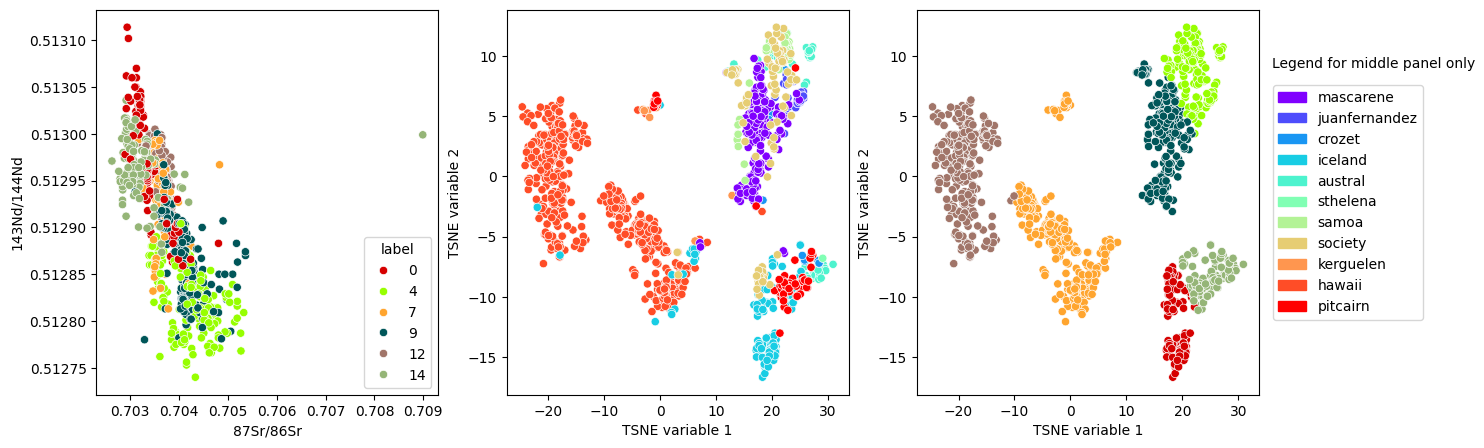

In [ ]:
# Final filter for FOZO sub-groups
tsne_result_SrNdPb_selhotspots_FOZO = SrNdPb_selhotspots_tsne_kmeans_labels[SrNdPb_selhotspots_tsne_kmeans_labels['label'].isin([0, 4, 7, 9, 12, 14])].copy()
tsne_result_SrNdPbTE_selhotspots_FOZO = SrNdPbTE_selhotspots_tsne_kmeans_labels[SrNdPbTE_selhotspots_tsne_kmeans_labels['label'].isin([0, 4, 7, 9, 12, 14])].copy()
tsne_result_HeSrNdPb_selhotspots_FOZO = HeSrNdPb_selhotspots_tsne_kmeans_labels[HeSrNdPb_selhotspots_tsne_kmeans_labels['label'].isin([0, 4, 7, 9, 12, 14])].copy()

# Filter Sr-Nd-Pb sub-datasets
SrNdPb_selhotspots_dataonly_FOZO = SrNdPb_selhotspots_dataonly_wcluster[SrNdPb_selhotspots_dataonly_wcluster['label'].isin([0, 4, 7, 9, 12, 14])].drop(columns=['label'])
SrNdPb_selhotspots_FOZO = SrNdPb_selhotspots_wcluster[SrNdPb_selhotspots_wcluster['label'].isin([0, 4, 7, 9, 12, 14])]

# Visualize final filtered data
palette_FOZO = [palette[i] for i in [0, 4, 7, 9, 12, 14]]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.scatterplot(x=SrNdPb_selhotspots_FOZO['SR87_SR86'], y=SrNdPb_selhotspots_FOZO['ND143_ND144'], hue=SrNdPb_selhotspots_FOZO['label'], palette=palette_FOZO, ax=ax1)
ax1.set_xlabel('87Sr/86Sr')
ax1.set_ylabel('143Nd/144Nd')

sns.scatterplot(x=tsne_result_SrNdPb_selhotspots_FOZO['tsne_1'], y=tsne_result_SrNdPb_selhotspots_FOZO['tsne_2'], hue=tsne_result_SrNdPb_selhotspots_FOZO['hotspot'], palette=color_dict, ax=ax2)
ax2.set_xlabel('TSNE variable 1')
ax2.set_ylabel('TSNE variable 2')
ax2.legend_.remove()

sns.scatterplot(x=tsne_result_SrNdPb_selhotspots_FOZO['tsne_1'], y=tsne_result_SrNdPb_selhotspots_FOZO['tsne_2'], hue=tsne_result_SrNdPb_selhotspots_FOZO['label'], palette=palette_FOZO, ax=ax3)
ax3.set_xlabel('TSNE variable 1')
ax3.set_ylabel('TSNE variable 2')
ax3.legend_.remove()

plt.legend(handles=patches, loc='right', bbox_to_anchor=(1.5, 0.5))
plt.text(s='Legend for middle panel only', x=36, y=9)
plt.show()

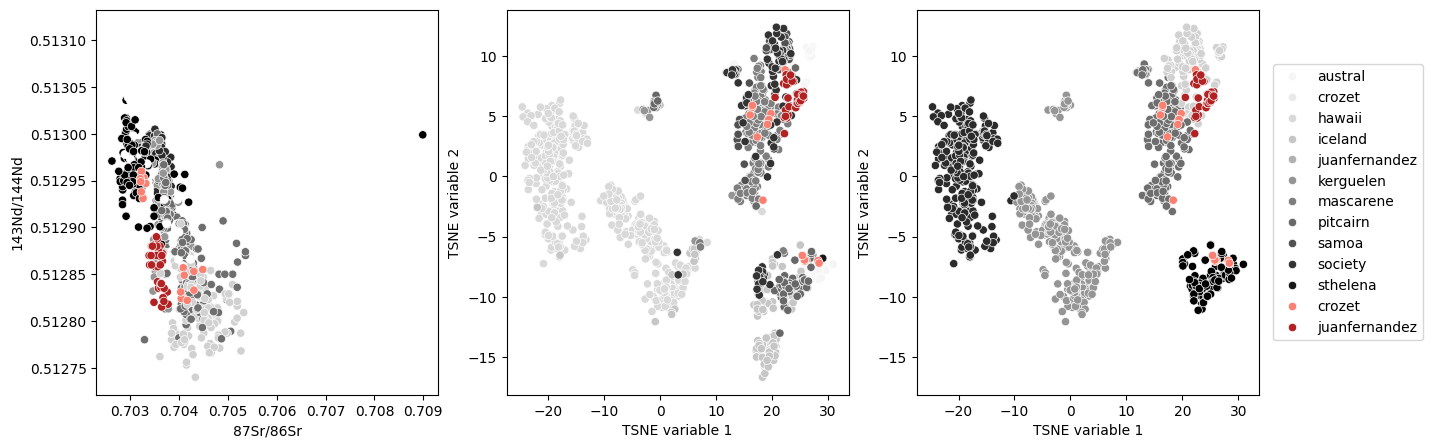

In [ ]:
# Replot to highlight Juan Fernandez and Crozet samples
tsne_result_SrNdPb_selhotspots_FOZO_JFC = tsne_result_SrNdPb_selhotspots_FOZO[tsne_result_SrNdPb_selhotspots_FOZO['hotspot'].isin(['juanfernandez', 'crozet'])]

# Filter Sr-Nd-Pb sub-datasets
SrNdPb_selhotspots_FOZO_JFC = SrNdPb_selhotspots_FOZO[SrNdPb_selhotspots_FOZO['hotspot'].isin(['juanfernandez', 'crozet'])]

# Visualize final filtered data
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.scatterplot(x=SrNdPb_selhotspots_FOZO['SR87_SR86'], y=SrNdPb_selhotspots_FOZO['ND143_ND144'], hue=SrNdPb_selhotspots_FOZO['label'], palette='Greys', ax=ax1)
sns.scatterplot(x=SrNdPb_selhotspots_FOZO_JFC['SR87_SR86'], y=SrNdPb_selhotspots_FOZO_JFC['ND143_ND144'], hue=SrNdPb_selhotspots_FOZO_JFC['hotspot'], palette=['salmon', 'firebrick'], ax=ax1)
ax1.set_xlabel('87Sr/86Sr')
ax1.set_ylabel('143Nd/144Nd')
ax1.legend_.remove()

sns.scatterplot(x=tsne_result_SrNdPb_selhotspots_FOZO['tsne_1'], y=tsne_result_SrNdPb_selhotspots_FOZO['tsne_2'], hue=tsne_result_SrNdPb_selhotspots_FOZO['hotspot'], palette='Greys', ax=ax2)
sns.scatterplot(x=tsne_result_SrNdPb_selhotspots_FOZO_JFC['tsne_1'], y=tsne_result_SrNdPb_selhotspots_FOZO_JFC['tsne_2'], hue=tsne_result_SrNdPb_selhotspots_FOZO_JFC['hotspot'], palette=['salmon', 'firebrick'], ax=ax2)
ax2.set_xlabel('TSNE variable 1')
ax2.set_ylabel('TSNE variable 2')
ax2.legend(loc='right', bbox_to_anchor=(2.7, 0.5))

sns.scatterplot(x=tsne_result_SrNdPb_selhotspots_FOZO['tsne_1'], y=tsne_result_SrNdPb_selhotspots_FOZO['tsne_2'], hue=tsne_result_SrNdPb_selhotspots_FOZO['label'], palette='Greys', ax=ax3)
sns.scatterplot(x=tsne_result_SrNdPb_selhotspots_FOZO_JFC['tsne_1'], y=tsne_result_SrNdPb_selhotspots_FOZO_JFC['tsne_2'], hue=tsne_result_SrNdPb_selhotspots_FOZO_JFC['hotspot'], palette=['salmon', 'firebrick'], ax=ax3)
ax3.set_xlabel('TSNE variable 1')
ax3.set_ylabel('TSNE variable 2')
ax3.legend_.remove()

plt.show()

The spread out nature of Crozet's isotopic composition follows what is concluded from binary plots, however the clustering behavior of Crozet samples seems even more complex and should be cross-referenced with its u142Nd compositions.

In [ ]:
# Filter Sr-Nd-Pb-TE and He-Sr-Nd-Pb sub-datasets based on cluster labels for corresponding samples in the Sr-Nd-Pb sub-dataset
# Create copy datasets
SrNdPbTE_selhotspots_dataonly_wcluster = SrNdPbTE_selhotspots_dataonly.copy().reset_index()
SrNdPbTE_selhotspots_wcluster = SrNdPbTE_selhotspots.copy().reset_index()

HeSrNdPb_selhotspots_dataonly_wcluster = HeSrNdPb_selhotspots_dataonly.copy().reset_index()
HeSrNdPb_selhotspots_wcluster = HeSrNdPb_selhotspots.copy().reset_index()

# Create masked datasets from the Sr-Nd-Pb sub-dataset
SrNdPb_selhotspots_wcluster_maskTE = SrNdPb_selhotspots_wcluster.loc[SrNdPb_selhotspots_wcluster['SAMPLE NAME'].isin(SrNdPbTE_selhotspots['SAMPLE NAME'])].reset_index()
SrNdPb_selhotspots_wcluster_maskHe = SrNdPb_selhotspots_wcluster.loc[SrNdPb_selhotspots_wcluster['SAMPLE NAME'].isin(HeSrNdPb_selhotspots['SAMPLE NAME'])].reset_index()

# Add cluster labels from Sr-Nd-Pb sub-dataset to other sub-datasets
SrNdPbTE_selhotspots_dataonly_wcluster['label'] = SrNdPb_selhotspots_wcluster_maskTE['label']
SrNdPbTE_selhotspots_wcluster['label'] = SrNdPb_selhotspots_wcluster_maskTE['label']

HeSrNdPb_selhotspots_dataonly_wcluster['label'] = SrNdPb_selhotspots_wcluster_maskHe['label']
HeSrNdPb_selhotspots_wcluster['label'] = SrNdPb_selhotspots_wcluster_maskHe['label']

# Filter for FOZO-associated clusters
SrNdPbTE_selhotspots_dataonly_FOZO = SrNdPbTE_selhotspots_dataonly_wcluster[SrNdPbTE_selhotspots_dataonly_wcluster['label'].isin([0, 4, 7, 9, 12, 14])].drop(columns=['label']).drop(columns=['index'])
SrNdPbTE_selhotspots_FOZO = SrNdPbTE_selhotspots_wcluster[SrNdPbTE_selhotspots_wcluster['label'].isin([0, 4, 7, 9, 12, 14])]

HeSrNdPb_selhotspots_dataonly_FOZO = HeSrNdPb_selhotspots_dataonly_wcluster[HeSrNdPb_selhotspots_dataonly_wcluster['label'].isin([0, 4, 7, 9, 12, 14])].drop(columns=['label']).drop(columns=['index'])
HeSrNdPb_selhotspots_FOZO = HeSrNdPb_selhotspots_wcluster[HeSrNdPb_selhotspots_wcluster['label'].isin([0, 4, 7, 9, 12, 14])]

# Print sizes of FOZO-filtered sub-datasets
print("Total rows in Sr-Nd-Pb dataset:", len(SrNdPb_selhotspots_FOZO))
print("Total rows in Sr-Nd-Pb-trace element dataset:", len(SrNdPbTE_selhotspots_FOZO))
print("Total rows in He-Sr-Nd-Pb dataset:", len(HeSrNdPb_selhotspots_FOZO))

Total rows in Sr-Nd-Pb dataset: 1138
Total rows in Sr-Nd-Pb-trace element dataset: 616
Total rows in He-Sr-Nd-Pb dataset: 65


# **6. Re-analysis of clustering among FOZO-like samples only**

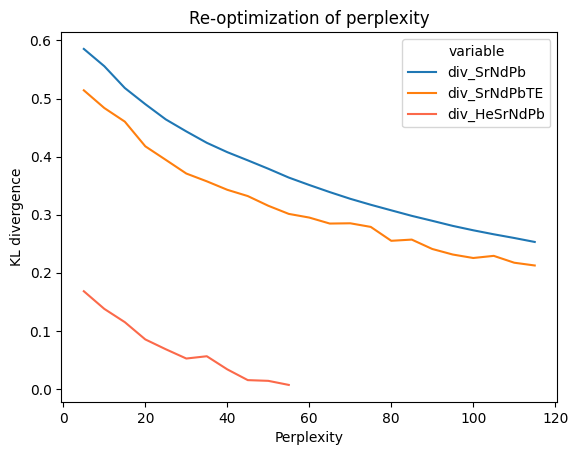

In [ ]:
# Re-optimize perplexity in FOZO sub-datasets
perplexity_FOZO = np.arange(5, 120, 5)
perplexity_FOZO_He = np.arange(5, 60, 5)
divergence_SrNdPb_FOZO = []
divergence_SrNdPbTE_FOZO = []
divergence_HeSrNdPb_FOZO = []

for i in perplexity_FOZO:
  tsne_SrNdPb_FOZO = TSNE(n_components=2, init='pca', perplexity=i)
  SrNdPb_allhotspots_FOZO_optperp = tsne_SrNdPb_FOZO.fit_transform(SrNdPb_selhotspots_dataonly_FOZO)

  tsne_SrNdPbTE_FOZO = TSNE(n_components=2, init='pca', perplexity=i)
  SrNdPbTE_allhotspots_FOZO_optperp = tsne_SrNdPbTE_FOZO.fit_transform(SrNdPbTE_selhotspots_dataonly_FOZO)

  divergence_SrNdPb_FOZO.append(tsne_SrNdPb_FOZO.kl_divergence_)
  divergence_SrNdPbTE_FOZO.append(tsne_SrNdPbTE_FOZO.kl_divergence_)

for i in perplexity_FOZO_He:
  tsne_HeSrNdPb_FOZO = TSNE(n_components=2, init='pca', perplexity=i)
  HeSrNdPb_allhotspots_FOZO_optperp = tsne_HeSrNdPb_FOZO.fit_transform(HeSrNdPb_selhotspots_dataonly_FOZO)
  divergence_HeSrNdPb_FOZO.append(tsne_HeSrNdPb_FOZO.kl_divergence_)

# Organize results
results = pd.DataFrame({'perplexity': perplexity_FOZO,
                        'div_SrNdPb': divergence_SrNdPb_FOZO,
                        'div_SrNdPbTE': divergence_SrNdPbTE_FOZO})
results = pd.melt(results, ['perplexity'])
results_He = pd.DataFrame({'perplexity': perplexity_FOZO_He,
                           'div_HeSrNdPb': divergence_HeSrNdPb_FOZO})
results_He = pd.melt(results_He, ['perplexity'])

# Produce plot
sns.lineplot(data=results, x='perplexity', y='value', hue='variable').set(title='Re-optimization of perplexity', xlabel='Perplexity', ylabel='KL divergence')
sns.lineplot(data=results_He, x='perplexity', y='value', hue='variable', palette='Reds')
plt.show()

Based on the results, a perplexity of 70 is maintained for the Sr-Nd-Pb and Sr-Nd-Pb-TE sub-datasets, and a perplexity of 50 is selected for the He-Sr-Nd-Pb sub-dataset

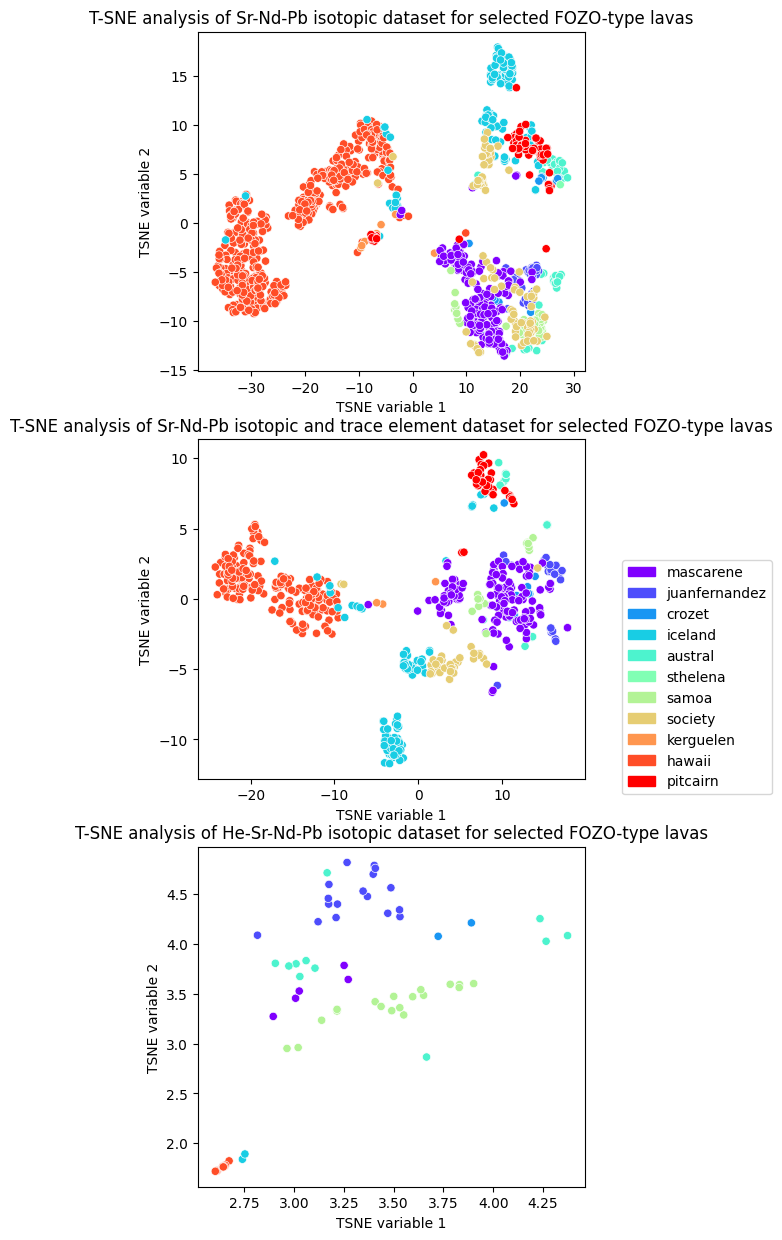

In [ ]:
# Perform t-SNE on FOZO-filtered dataset
# Perform clustering model and plot results
tsne_SrNdPb_FOZO = TSNE(n_components=2, init='pca', perplexity=70, random_state=23)
tsne_SrNdPbTE_FOZO = TSNE(n_components=2, init='pca', perplexity=70, random_state=23)
tsne_HeSrNdPb_FOZO = TSNE(n_components=2, init='pca', perplexity=50, random_state=23)

SrNdPb_selhotspots_FOZO_tsne = tsne_SrNdPb_FOZO.fit_transform(SrNdPb_selhotspots_dataonly_FOZO)
SrNdPbTE_selhotspots_FOZO_tsne = tsne_SrNdPbTE_FOZO.fit_transform(SrNdPbTE_selhotspots_dataonly_FOZO)
HeSrNdPb_selhotspots_FOZO_tsne = tsne_HeSrNdPb_FOZO.fit_transform(HeSrNdPb_selhotspots_dataonly_FOZO)

# Organize results
tsne_result_SrNdPb_selhotspots_FOZO = pd.DataFrame({'tsne_1': SrNdPb_selhotspots_FOZO_tsne[:,0],
                                                    'tsne_2': SrNdPb_selhotspots_FOZO_tsne[:,1],
                                                    'hotspot': SrNdPb_selhotspots_FOZO['hotspot']})
tsne_result_SrNdPbTE_selhotspots_FOZO = pd.DataFrame({'tsne_1': SrNdPbTE_selhotspots_FOZO_tsne[:,0],
                                                      'tsne_2': SrNdPbTE_selhotspots_FOZO_tsne[:,1],
                                                      'hotspot': SrNdPbTE_selhotspots_FOZO['hotspot']})
tsne_result_HeSrNdPb_selhotspots_FOZO = pd.DataFrame({'tsne_1': HeSrNdPb_selhotspots_FOZO_tsne[:,0],
                                                      'tsne_2': HeSrNdPb_selhotspots_FOZO_tsne[:,1],
                                                      'hotspot': HeSrNdPb_selhotspots_FOZO['hotspot']})

# Visualize results
# Prepare for plotting
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(5, 15))
n = len(selhotspots)
colors = cm.rainbow(np.linspace(0,1,n))
color_dict = {selhotspots[i]: colors[i] for i in range(n)}
patches = []
for hotspot in selhotspots:
  patches.append(mpatches.Patch(color=color_dict[hotspot], label=hotspot))

# Create plots
sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result_SrNdPb_selhotspots_FOZO, hue='hotspot', palette=color_dict, ax=ax1)
ax1.set_title('T-SNE analysis of Sr-Nd-Pb isotopic dataset for selected FOZO-type lavas')
ax1.set_xlabel('TSNE variable 1')
ax1.set_ylabel('TSNE variable 2')
ax1.legend_.remove()

sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result_SrNdPbTE_selhotspots_FOZO, hue='hotspot', palette=color_dict, ax=ax2)
ax2.set_title('T-SNE analysis of Sr-Nd-Pb isotopic and trace element dataset for selected FOZO-type lavas')
ax2.set_xlabel('TSNE variable 1')
ax2.set_ylabel('TSNE variable 2')
ax2.legend_.remove()

sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result_HeSrNdPb_selhotspots_FOZO, hue='hotspot', palette=color_dict, ax=ax3)
ax3.set_title('T-SNE analysis of He-Sr-Nd-Pb isotopic dataset for selected FOZO-type lavas')
ax3.set_xlabel('TSNE variable 1')
ax3.set_ylabel('TSNE variable 2')
ax3.legend_.remove()

# Add legend & show plot
plt.legend(handles=patches, loc='right', bbox_to_anchor=(1.5, 1.5))
plt.show()

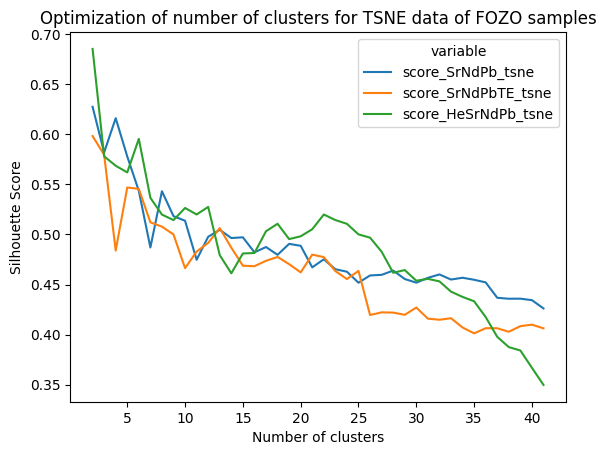

In [ ]:
# Perform k-means clustering analysis on t-SNE dimension-reduced data for FOZO hotspots
# Optimize number of clusters for each sub-dataset
# Produce data-only DataFrames
tsne_result_SrNdPb_dataonly_FOZO = tsne_result_SrNdPb_selhotspots_FOZO.drop(columns=['hotspot'])
tsne_result_SrNdPbTE_dataonly_FOZO = tsne_result_SrNdPbTE_selhotspots_FOZO.drop(columns=['hotspot'])
tsne_result_HeSrNdPb_dataonly_FOZO = tsne_result_HeSrNdPb_selhotspots_FOZO.drop(columns=['hotspot'])

# Set testing range for clusters and create empty dataset
clusters = range(2, 42)
fits_SrNdPb_tsne_FOZO = []
fits_SrNdPbTE_tsne_FOZO = []
fits_HeSrNdPb_tsne_FOZO = []
score_SrNdPb_tsne_FOZO = []
score_SrNdPbTE_tsne_FOZO = []
score_HeSrNdPb_tsne_FOZO = []

# Initialize and fit clustering models
for cluster in clusters:
  kmeans_SrNdPb_tsne_FOZO = KMeans(n_clusters=cluster, random_state=23, n_init='auto')
  kmeans_SrNdPbTE_tsne_FOZO = KMeans(n_clusters=cluster, random_state=23, n_init='auto')
  kmeans_HeSrNdPb_tsne_FOZO = KMeans(n_clusters=cluster, random_state=23, n_init='auto')

  SrNdPb_tsne_kmeans_FOZO = kmeans_SrNdPb_tsne_FOZO.fit(tsne_result_SrNdPb_dataonly_FOZO)
  SrNdPbTE_tsne_kmeans_FOZO = kmeans_SrNdPbTE_tsne_FOZO.fit(tsne_result_SrNdPbTE_dataonly_FOZO)
  HeSrNdPb_tsne_kmeans_FOZO = kmeans_HeSrNdPb_tsne_FOZO.fit(tsne_result_HeSrNdPb_dataonly_FOZO)

  fits_SrNdPb_tsne_FOZO.append(kmeans_SrNdPb_tsne_FOZO)
  fits_SrNdPbTE_tsne_FOZO.append(kmeans_SrNdPbTE_tsne_FOZO)
  fits_HeSrNdPb_tsne_FOZO.append(kmeans_HeSrNdPb_tsne_FOZO)

  score_SrNdPb_tsne_FOZO.append(silhouette_score(tsne_result_SrNdPb_dataonly_FOZO, kmeans_SrNdPb_tsne_FOZO.labels_, metric='euclidean'))
  score_SrNdPbTE_tsne_FOZO.append(silhouette_score(tsne_result_SrNdPbTE_dataonly_FOZO, kmeans_SrNdPbTE_tsne_FOZO.labels_, metric='euclidean'))
  score_HeSrNdPb_tsne_FOZO.append(silhouette_score(tsne_result_HeSrNdPb_dataonly_FOZO, kmeans_HeSrNdPb_tsne_FOZO.labels_, metric='euclidean'))

# Organize results
results = pd.DataFrame({'clusters': clusters,
                        'score_SrNdPb_tsne': score_SrNdPb_tsne_FOZO,
                        'score_SrNdPbTE_tsne': score_SrNdPbTE_tsne_FOZO,
                        'score_HeSrNdPb_tsne': score_HeSrNdPb_tsne_FOZO})
results = pd.melt(results, ['clusters'])

# Produce plot
sns.lineplot(data=results, x='clusters', y='value', hue='variable').set(title='Optimization of number of clusters for TSNE data of FOZO samples', xlabel='Number of clusters', ylabel='Silhouette Score')
plt.show()

Although the score continues to decrease through 40 clusters, there is an apparent plateau around 15 clusters, so for initial analyis this number of clusters is selected.

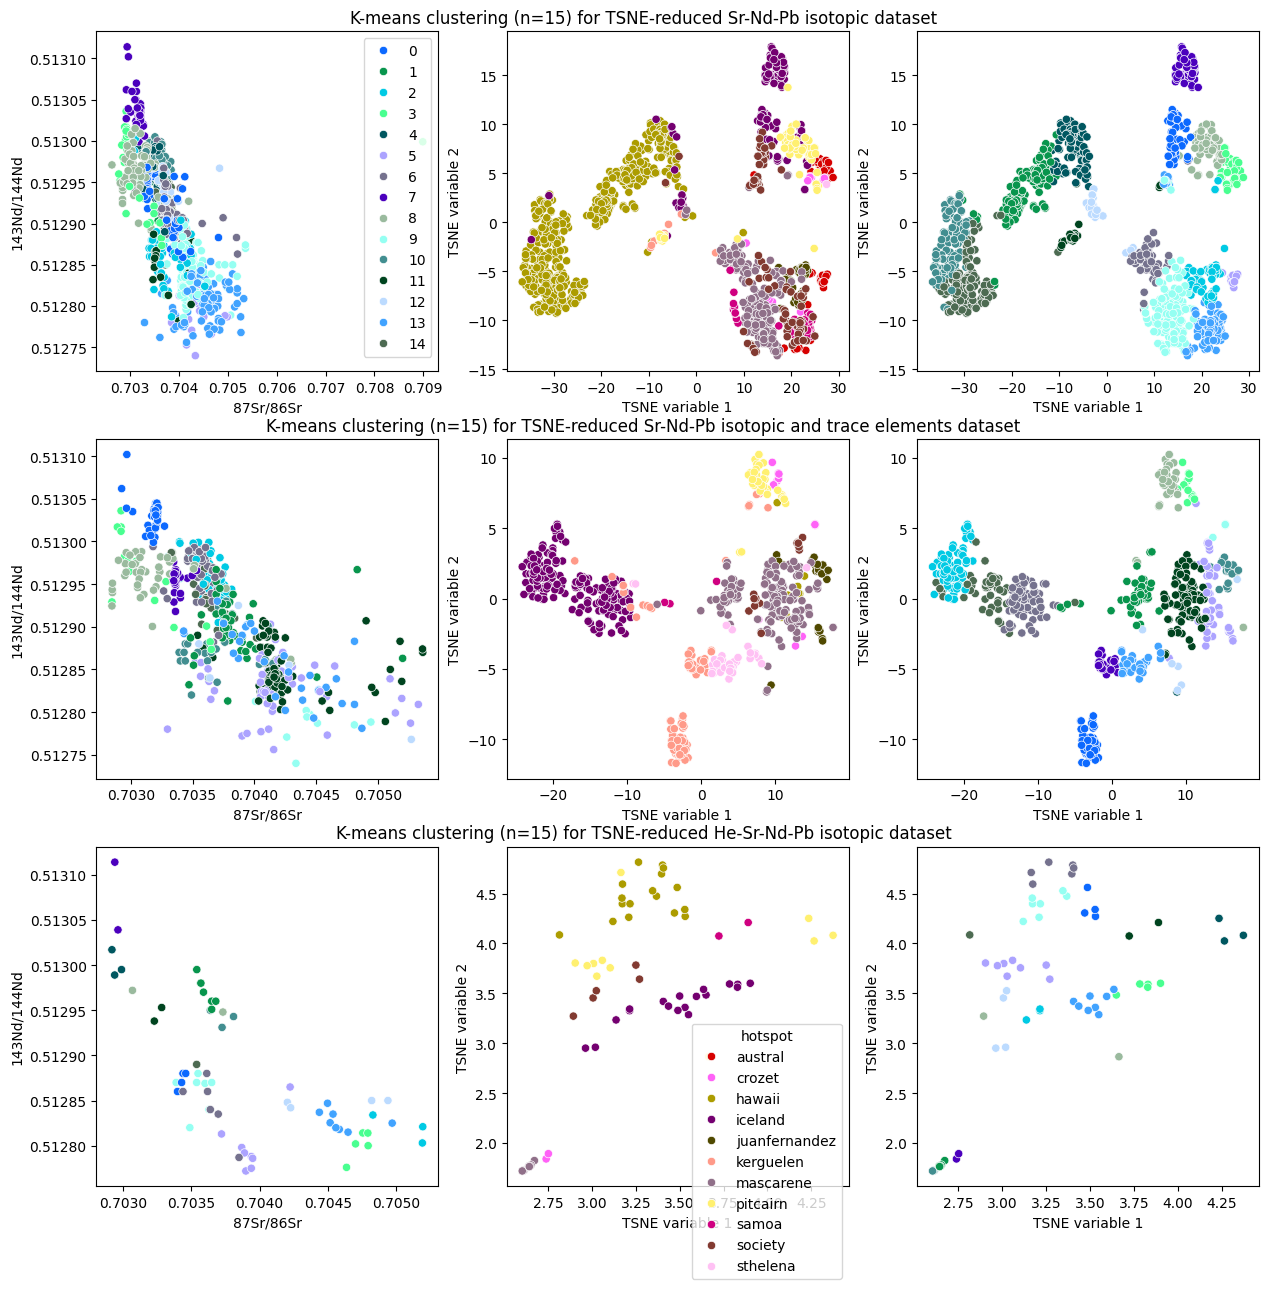

In [ ]:
# Initialize and fit models for each FOZO sub-dataset, n(clusters) = 15
kmeans_SrNdPb_FOZO = KMeans(n_clusters=15, random_state=23, n_init='auto')
kmeans_SrNdPbTE_FOZO = KMeans(n_clusters=15, random_state=23, n_init='auto')
kmeans_HeSrNdPb_FOZO = KMeans(n_clusters=15, random_state=23, n_init='auto')

SrNdPb_kmeans_FOZO = kmeans_SrNdPb_FOZO.fit(SrNdPb_selhotspots_dataonly_FOZO)
SrNdPbTE_kmeans_FOZO = kmeans_SrNdPbTE_FOZO.fit(SrNdPbTE_selhotspots_dataonly_FOZO)
HeSrNdPb_kmeans_FOZO = kmeans_HeSrNdPb_FOZO.fit(HeSrNdPb_selhotspots_dataonly_FOZO)

# Visualize results
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = [axes[i, j] for i in range(3) for j in range(3)]
palette_clusters = sns.color_palette(cc.glasbey_cool, n_colors=15)
palette_hotspots_SrNdPb = sns.color_palette(cc.glasbey_warm, n_colors=11)
palette_hotspots_SrNdPbTE = [palette_hotspots_SrNdPb[i] for i in [1, 2, 3, 5, 4, 8, 6, 7, 9, 10]]
palette_hotspots_HeSrNdPb = [palette_hotspots_SrNdPb[i] for i in [7, 8, 6, 1, 2, 9, 3]]

sns.scatterplot(x=SrNdPb_selhotspots_FOZO['SR87_SR86'], y=SrNdPb_selhotspots_FOZO['ND143_ND144'], hue=SrNdPb_kmeans_FOZO.labels_, palette=palette_clusters, ax=ax1)
ax1.set_title('K-means clustering (n=15) for TSNE-reduced Sr-Nd-Pb isotopic dataset', x=1.6, y=1)
ax1.set_xlabel('87Sr/86Sr')
ax1.set_ylabel('143Nd/144Nd')

sns.scatterplot(x=tsne_result_SrNdPb_selhotspots_FOZO['tsne_1'], y=tsne_result_SrNdPb_selhotspots_FOZO['tsne_2'], hue=tsne_result_SrNdPb_selhotspots_FOZO['hotspot'], palette=palette_hotspots_SrNdPb, ax=ax2)
ax2.set_xlabel('TSNE variable 1')
ax2.set_ylabel('TSNE variable 2')

sns.scatterplot(x=tsne_result_SrNdPb_selhotspots_FOZO['tsne_1'], y=tsne_result_SrNdPb_selhotspots_FOZO['tsne_2'], hue=SrNdPb_kmeans_FOZO.labels_, palette=palette_clusters, ax=ax3)
ax3.set_xlabel('TSNE variable 1')
ax3.set_ylabel('TSNE variable 2')
ax3.legend_.remove()

sns.scatterplot(x=SrNdPbTE_selhotspots_FOZO['SR87_SR86'], y=SrNdPbTE_selhotspots_FOZO['ND143_ND144'], hue=SrNdPbTE_kmeans_FOZO.labels_, palette=palette_clusters, ax=ax4)
ax4.set_title('K-means clustering (n=15) for TSNE-reduced Sr-Nd-Pb isotopic and trace elements dataset', x=1.6, y=1)
ax4.set_xlabel('87Sr/86Sr')
ax4.set_ylabel('143Nd/144Nd')
ax4.legend_.remove()

sns.scatterplot(x=tsne_result_SrNdPbTE_selhotspots_FOZO['tsne_1'], y=tsne_result_SrNdPbTE_selhotspots_FOZO['tsne_2'], hue=tsne_result_SrNdPbTE_selhotspots_FOZO['hotspot'], palette=palette_hotspots_SrNdPbTE, ax=ax5)
ax5.set_xlabel('TSNE variable 1')
ax5.set_ylabel('TSNE variable 2')
ax5.legend_.remove()

sns.scatterplot(x=tsne_result_SrNdPbTE_selhotspots_FOZO['tsne_1'], y=tsne_result_SrNdPbTE_selhotspots_FOZO['tsne_2'], hue=SrNdPbTE_kmeans_FOZO.labels_, palette=palette_clusters, ax=ax6)
ax6.set_xlabel('TSNE variable 1')
ax6.set_ylabel('TSNE variable 2')
ax6.legend_.remove()

sns.scatterplot(x=HeSrNdPb_selhotspots_FOZO['SR87_SR86'], y=HeSrNdPb_selhotspots_FOZO['ND143_ND144'], hue=HeSrNdPb_kmeans_FOZO.labels_, palette=palette_clusters, ax=ax7)
ax7.set_title('K-means clustering (n=15) for TSNE-reduced He-Sr-Nd-Pb isotopic dataset', x=1.6, y=1)
ax7.set_xlabel('87Sr/86Sr')
ax7.set_ylabel('143Nd/144Nd')
ax7.legend_.remove()

sns.scatterplot(x=tsne_result_HeSrNdPb_selhotspots_FOZO['tsne_1'], y=tsne_result_HeSrNdPb_selhotspots_FOZO['tsne_2'], hue=tsne_result_HeSrNdPb_selhotspots_FOZO['hotspot'], palette=palette_hotspots_HeSrNdPb, ax=ax8)
ax8.set_xlabel('TSNE variable 1')
ax8.set_ylabel('TSNE variable 2')
ax8.legend_.remove()

sns.scatterplot(x=tsne_result_HeSrNdPb_selhotspots_FOZO['tsne_1'], y=tsne_result_HeSrNdPb_selhotspots_FOZO['tsne_2'], hue=HeSrNdPb_kmeans_FOZO.labels_, palette=palette_clusters, ax=ax9)
ax9.set_xlabel('TSNE variable 1')
ax9.set_ylabel('TSNE variable 2')
ax9.legend_.remove()

# Add legend for hotspots & show plot
ax2.set_zorder(1)
ax2.legend_.set_bbox_to_anchor((1, -1.9))
#plt.legend(handles=patches, loc='right', bbox_to_anchor=(1.5, 1.6))
#plt.text(s='Legend for middle panels only', x=6.5, y=10.2)
plt.show()

# **7. Conclusion**

FOZO hotspots show statistical diversity that is evidenced by the formation of distinct clusters in a reduced-dimensional space. Visually, there are at least five clusters within the FOZO group; the error minimization exercise for k-means clustering implies there could be as many as 15.

Juan Fernandez and Crozet samples plot in distinct clusters, confirming that they have statistically distinct isotopic signatures from each other, with Crozet displaying substantially more heterogeneity than Juan Fernandez. The fact that these two hotspots also have statistically distinct u142Nd compositions raises the question of whether geochemical heterogeneity in volcanic hotspots began to arise more than 4 billion years ago, and some part of that ancient heterogeneity has survived until today.

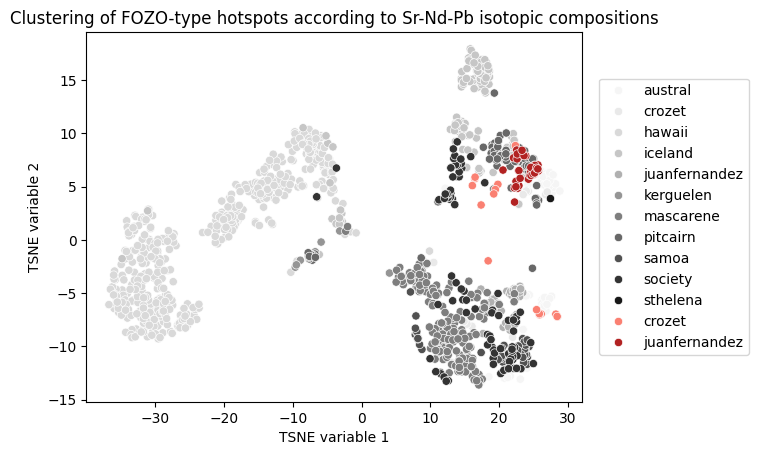

In [ ]:
# Produce final figures highlighting position of Juan Fernandez and Crozet samples
fig, ax = plt.subplots()
sns.scatterplot(x=tsne_result_SrNdPb_selhotspots_FOZO['tsne_1'], y=tsne_result_SrNdPb_selhotspots_FOZO['tsne_2'], hue=tsne_result_SrNdPb_selhotspots_FOZO['hotspot'], palette='Greys', ax=ax)
sns.scatterplot(x=tsne_result_SrNdPb_selhotspots_FOZO_JFC['tsne_1'], y=tsne_result_SrNdPb_selhotspots_FOZO_JFC['tsne_2'], hue=tsne_result_SrNdPb_selhotspots_FOZO_JFC['hotspot'], palette=['salmon', 'firebrick'], ax=ax)
ax.set_xlabel('TSNE variable 1')
ax.set_ylabel('TSNE variable 2')
ax.set_title('Clustering of FOZO-type hotspots according to Sr-Nd-Pb isotopic compositions')
ax.legend(loc='right', bbox_to_anchor=(1.35, 0.5))
plt.show()